# Lab #1 Images, optics, and the statistics of light

In [7]:
# Import necessary packages
import os
import math
import shutil
import struct
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.visualization import simple_norm
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.centroids import centroid_com
from scipy.stats import linregress
from scipy.optimize import curve_fit

# Optical Imager
**KEY STEPS:**
- **Build an optical system that can image the full extent of a Jupiter-sim, resolve Jupiter-sim’s red spot, and separate stars in a globular cluster-sim.**
- **Record your imager’s optical design, field-of-view, spatial resolution, and plate scale.**
- **How does your imager’s spatial resolution compare to the diffraction limit of your optical system?**



*GOAL*: Map an object to an image plane (image formation). \
\
**Thin-lens equation**:

$$
\frac{1}{f} = \frac{1}{i} + \frac{1}{o},
$$
where $f = \text{focal length of thin lens}$, $o = \text{distance from object to thin lens}$ and $i = \text{distance from image to thin lens}$. 

**Focal length** = determines how strongly a system converges or diverges recieved light, determines the extent of an image and the distance between two imaged objects on the focal plane. \
**Focal plane** = where your image comes to a focus \
**Combination of two lenses equation:** 
$$
\frac{1}{F} = \frac{1}{f_1} + \frac{1}{f_2} - \frac{d}{f_1 * f_2}
$$

where $F = \text{combined focal length}$, $f_1 = \text{focal length of lens 1}$, $f_2 = \text{focal length of lens 2}$ and $d = \text{distance between lenses}$.

### Parameters

In [1]:
# Detector
detector_width_pixels = 1440
detector_height_pixels = 1080
pixel_size_um = 3.45
wavelength_of_detector_nm = 500

In [2]:
# Lenses
focal_lengths_mm = [50, 75, 75, 100]

## 1.1 Plate Scale
*GOAL*: Determine an optimal imaging system with a plate scale that would allow to resolve two successive lines of the provided Ronchi mask. \
\
**Plate scale** = angular size of an object that can be imaged onto a particular linear size on the focal plane (angle / unit length) (radians / mm) (*prefered*: arcseconds / pixel)


$$
\begin{split}
\text{Plate Scale } (p) & = \frac{\text{angular separation}\,(\text{radians})}{\text{linear separation} (\text{mm})} = \frac{\text{pixel size (mm)}}{\text{focal length (mm)}} = \frac{\text{radians}}{\text{pixel}} * \left(\frac{206265\,\text{arcseconds}}{1\,\text{radian}} \right) = \frac{\text{arcseconds}}{\text{pixel}}
\end{split}
$$
Note 1: Larger plate scale = larger field of view, smaller plate scale = larger angular resolution
Note 2: Larger focal length = smaller plate scale, smaller focal length = larger plate scale
Note 3: Larger focal length = smaller field of view, smaller focal length = larger field of view

### Pre-known Parameters
By testing our optical setup, we can determine the distance between Ronchi lines

In [8]:
number_of_ronchi_lines = 22
distance_from_detector_to_ronchi_lines_cm = 7.5 + .9 + 22.7 + .9 + 7.6 # cm

In [9]:
def calculate_ronchi_line_separation_mm_and_arcseconds(number_of_ronchi_lines,
                                                       detector_width_pixels,
                                                       pixel_size_um,
                                                       distance_from_detector_to_ronchi_lines_cm):
    # mm
    pixel_size_mm = pixel_size_um / 1000 # Convert micro to milli         
    detector_width_mm = detector_width_pixels * pixel_size_mm 
    line_separation_mm = detector_width_mm / (number_of_ronchi_lines - 1)

    # arcseconds
    distance_from_detector_to_ronchi_lines_mm = distance_from_detector_to_ronchi_lines_cm * 10 # mm
    theta_radians = math.atan(line_separation_mm / distance_from_detector_to_ronchi_lines_mm) #radians
    theta_degrees = math.degrees(theta_radians) # degrees 
    theta_arcseconds = theta_degrees * 3600 # arcseconds
                                                           
    return line_separation_mm, theta_arcseconds

In [10]:
ronchi_line_separation_mm, ronchi_line_separation_arcseconds = calculate_ronchi_line_separation_mm_and_arcseconds(number_of_ronchi_lines=number_of_ronchi_lines,
                                                                                                                  detector_width_pixels=detector_width_pixels,
                                                                                                                  pixel_size_um=pixel_size_um,
                                                                                                                  distance_from_detector_to_ronchi_lines_cm=distance_from_detector_to_ronchi_lines_cm)

print(f"Separation between Ronchi lines is {np.round(ronchi_line_separation_mm,4)} (mm).")
print(f"Separation between Ronchi lines is {np.round(ronchi_line_separation_arcseconds,4)} (arcseconds).")

Separation between Ronchi lines is 0.2366 (mm).
Separation between Ronchi lines is 123.2231 (arcseconds).


### Determining Plate-Scale

In [11]:
number_of_pixels_to_resolve = 13

In [12]:
def calculate_needed_plate_scale_and_field_of_view(size_of_object_arcseconds,
                                                   detector_width_pixels,
                                                   number_of_pixels_to_resolve):
    # Plate-scale
    plate_scale = size_of_object_arcseconds / number_of_pixels_to_resolve
                                                       
    # Field of View
    field_of_view = plate_scale * detector_width_pixels
                                                       
    return plate_scale, field_of_view

In [13]:
ronchi_lines_plate_scale, ronchi_lines_field_of_view = calculate_needed_plate_scale_and_field_of_view(size_of_object_arcseconds=ronchi_line_separation_arcseconds,
                                                                                                      detector_width_pixels=detector_width_pixels,
                                                                                                      number_of_pixels_to_resolve=number_of_pixels_to_resolve)

                                                                                                      
print(f"Required plate scale for Ronchi line separation is {np.round(ronchi_lines_plate_scale,4)} (arcseconds / pixel).")
print(f"Field of view corresponding to required plate scale is {np.round(ronchi_lines_field_of_view,4)} (arcseconds).")
                                                                                                      

Required plate scale for Ronchi line separation is 9.4787 (arcseconds / pixel).
Field of view corresponding to required plate scale is 13649.3298 (arcseconds).


In [14]:
def calculate_given_plate_scale_and_field_of_view(focal_length_mm,
                                                  pixel_size_um,
                                                  detector_width_pixels):
    pixel_size_mm = pixel_size_um / 1000
    plate_scale = (206265 * pixel_size_mm) / focal_length_mm
    field_of_view = plate_scale * detector_width_pixels
    return plate_scale, field_of_view

In [15]:
plate_scale_for_50mm, field_of_view_for_50mm = calculate_given_plate_scale_and_field_of_view(focal_length_mm=focal_lengths_mm[0],
                                                                                             pixel_size_um=pixel_size_um,
                                                                                             detector_width_pixels=detector_width_pixels)

plate_scale_for_75mm, field_of_view_for_75mm = calculate_given_plate_scale_and_field_of_view(focal_length_mm=focal_lengths_mm[1],
                                                                                             pixel_size_um=pixel_size_um,
                                                                                             detector_width_pixels=detector_width_pixels)

plate_scale_for_100mm, field_of_view_for_100mm = calculate_given_plate_scale_and_field_of_view(focal_length_mm=focal_lengths_mm[3],
                                                                                              pixel_size_um=pixel_size_um,
                                                                                              detector_width_pixels=detector_width_pixels)

print(f"For {focal_lengths_mm[0]}mm lens, plate scale is {np.round(plate_scale_for_50mm,4)} (arcseconds / pixel) and field of view is {np.round(field_of_view_for_50mm, 4)} (arcseconds).") 
print(f"For {focal_lengths_mm[1]}mm lens, plate scale is {np.round(plate_scale_for_75mm,4)} (arcseconds / pixel) and field of view is {np.round(field_of_view_for_75mm, 4)} (arcseconds).") 
print(f"For {focal_lengths_mm[3]}mm lens, plate scale is {np.round(plate_scale_for_100mm,4)} (arcseconds / pixel) and field of view is {np.round(field_of_view_for_100mm, 4)} (arcseconds).") 

For 50mm lens, plate scale is 14.2323 (arcseconds / pixel) and field of view is 20494.4904 (arcseconds).
For 75mm lens, plate scale is 9.4882 (arcseconds / pixel) and field of view is 13662.9936 (arcseconds).
For 100mm lens, plate scale is 7.1161 (arcseconds / pixel) and field of view is 10247.2452 (arcseconds).


### Calculating Diffraction-limit of Detector

In [16]:
def calculate_diffraction_limit_arcseconds(wavelength_of_detector_nm, pixel_size_um, detector_width_pixels):
    pixel_size_nm = pixel_size_um * 1000 # um to nm
    detector_width_nm = detector_width_pixels * pixel_size_nm 

    diffraction_limit_of_detector_radians = 1.22 * (wavelength_of_detector_nm / detector_width_nm)
    diffraction_limit_of_detector_arcseconds = diffraction_limit_of_detector_radians * 206265

    return diffraction_limit_of_detector_arcseconds

In [17]:
diffraction_limit_of_detector_arcseconds = calculate_diffraction_limit_arcseconds(wavelength_of_detector_nm=wavelength_of_detector_nm,
                                                                                  pixel_size_um=pixel_size_um,
                                                                                  detector_width_pixels=detector_width_pixels)

print(f"Diffraction limit: {diffraction_limit_of_detector_arcseconds:.2f} arcseconds")

Diffraction limit: 25.33 arcseconds


## 1.2 Field of View
*GOAL*: Determine an optimal imaging system that is capable of imaging the entire extent of Jupiter in a single exposure.

In [14]:
height_of_jupiter_cm = 10.3
width_of_jupiter_cm = 11.0
distance_from_detector_to_jupiter_cm = .75 + 1.4 + 4.5 + .9 + 157.5 
number_of_pixels_to_resolve_jupiter = 1000


In [15]:
def calculate_jupiter_arcseconds(detector_width_pixels,
                                 pixel_size_um,
                                 size_of_jupiter_cm,
                                 distance_from_detector_to_jupiter_cm):

    # arcseconds
    distance_from_detector_to_jupiter_mm = distance_from_detector_to_jupiter_cm * 10 # cm to mm
    size_of_jupiter_mm = size_of_jupiter_cm * 10 # cm to mm
    theta_radians = math.atan(size_of_jupiter_mm / distance_from_detector_to_jupiter_mm) #radians
    theta_degrees = math.degrees(theta_radians) # degrees 
    theta_arcseconds = theta_degrees * 3600 # arcseconds
                                                           
    return theta_arcseconds

In [16]:
height_of_jupiter_arcseconds = calculate_jupiter_arcseconds(detector_width_pixels=detector_width_pixels,
                                                            pixel_size_um=pixel_size_um,
                                                            size_of_jupiter_cm=height_of_jupiter_cm,
                                                            distance_from_detector_to_jupiter_cm=distance_from_detector_to_jupiter_cm)

width_of_jupiter_arcseconds = calculate_jupiter_arcseconds(detector_width_pixels=detector_width_pixels,
                                                           pixel_size_um=pixel_size_um,
                                                           size_of_jupiter_cm=width_of_jupiter_cm,
                                                           distance_from_detector_to_jupiter_cm=distance_from_detector_to_jupiter_cm)

print(f"Height of Jupiter is {np.round(height_of_jupiter_arcseconds,4)} (arcseconds) and width of Jupiter is {np.round(width_of_jupiter_arcseconds,4)} (arcseconds).")

Height of Jupiter is 12855.3529 (arcseconds) and width of Jupiter is 13726.5221 (arcseconds).


In [17]:
jupiter_plate_scale, jupiter_field_of_view = calculate_needed_plate_scale_and_field_of_view(size_of_object_arcseconds=width_of_jupiter_arcseconds,
                                                                                            detector_width_pixels=detector_width_pixels,
                                                                                            number_of_pixels_to_resolve=number_of_pixels_to_resolve_jupiter)

print(f"Required plate scale for resolving Jupiter is {np.round(jupiter_plate_scale,4)} (arcseconds / pixel).")
print(f"Field of view corresponding to required plate scale is {np.round(jupiter_field_of_view,4)} (arcseconds).")

Required plate scale for resolving Jupiter is 13.7265 (arcseconds / pixel).
Field of view corresponding to required plate scale is 19766.1919 (arcseconds).


In [18]:
jupiter_plate_scale, jupiter_field_of_view = calculate_needed_plate_scale_and_field_of_view(size_of_object_arcseconds=width_of_jupiter_arcseconds,
                                                                                            detector_width_pixels=detector_width_pixels,
                                                                                            number_of_pixels_to_resolve=number_of_pixels_to_resolve_jupiter)

### Combination of Lenses

In [21]:
minimum_distance_between_50mm_75mm_cm = 1.5 # cm
minimum_distance_between_75mm_75mm_cm = 1.4 # cm
minimum_distance_between_50mm_100mm_cm = .7 # cm
minimum_distance_between_75mm_100mm_cm = 1.4 # cm

In [22]:
def combined_focal_length_mm(focal_length_1_mm,
                             focal_length_2_mm,
                             distance_bewteen_lenses_cm):
                                 
    distance_between_lenses_mm = distance_bewteen_lenses_cm * 10 # mm
    
    return 1 / ((1 / focal_length_1_mm) + (1 / focal_length_2_mm) - (distance_between_lenses_mm / (focal_length_1_mm * focal_length_2_mm)))

In [23]:
combined_focal_length_50_75mm = combined_focal_length_mm(focal_length_1_mm=focal_lengths_mm[0],
                                                         focal_length_2_mm=focal_lengths_mm[1],
                                                         distance_bewteen_lenses_cm=minimum_distance_between_50mm_75mm_cm)

combined_focal_length_75_75mm = combined_focal_length_mm(focal_length_1_mm=focal_lengths_mm[1],
                                                         focal_length_2_mm=focal_lengths_mm[2],
                                                         distance_bewteen_lenses_cm=minimum_distance_between_75mm_75mm_cm)

combined_focal_length_50_100mm = combined_focal_length_mm(focal_length_1_mm=focal_lengths_mm[0],
                                                          focal_length_2_mm=focal_lengths_mm[3],
                                                          distance_bewteen_lenses_cm=minimum_distance_between_50mm_100mm_cm)

combined_focal_length_75_100mm = combined_focal_length_mm(focal_length_1_mm=focal_lengths_mm[1],
                                                          focal_length_2_mm=focal_lengths_mm[3],
                                                          distance_bewteen_lenses_cm=minimum_distance_between_75mm_100mm_cm)

print(f"Combined focal length of {np.round(focal_lengths_mm[0],4)} mm lens and {np.round(focal_lengths_mm[1],4)} mm lens is {np.round(combined_focal_length_50_75mm,4)} (mm).")
print(f"Combined focal length of {np.round(focal_lengths_mm[1],4)} mm lens and {np.round(focal_lengths_mm[2],4)} mm lens is {np.round(combined_focal_length_75_75mm,4)} (mm).")
print(f"Combined focal length of {np.round(focal_lengths_mm[0],4)} mm lens and {np.round(focal_lengths_mm[3],4)} mm lens is {np.round(combined_focal_length_50_100mm,4)} (mm).")
print(f"Combined focal length of {np.round(focal_lengths_mm[1],4)} mm lens and {np.round(focal_lengths_mm[3],4)} mm lens is {np.round(combined_focal_length_75_100mm,4)} (mm).")

Combined focal length of 50 mm lens and 75 mm lens is 34.0909 (mm).
Combined focal length of 75 mm lens and 75 mm lens is 41.3603 (mm).
Combined focal length of 50 mm lens and 100 mm lens is 34.965 (mm).
Combined focal length of 75 mm lens and 100 mm lens is 46.5839 (mm).


In [24]:
combined_focal_length_31_75mm = combined_focal_length_mm(focal_length_1_mm=focal_lengths_mm[0],
                                                          focal_length_2_mm=combined_focal_length_50_75mm,
                                                          distance_bewteen_lenses_cm=minimum_distance_between_75mm_75mm_cm)

print(f"Combined focal length of {np.round(combined_focal_length_50_75mm,4)} mm lens and {np.round(focal_lengths_mm[1],4)} mm lens is {np.round(combined_focal_length_31_75mm,4)} (mm).")

Combined focal length of 34.0909 mm lens and 75 mm lens is 24.3191 (mm).


In [25]:
combined_focal_length_23_100mm = combined_focal_length_mm(focal_length_1_mm=focal_lengths_mm[3],
                                                           focal_length_2_mm=combined_focal_length_31_75mm,
                                                           distance_bewteen_lenses_cm=minimum_distance_between_75mm_100mm_cm)

print(f"Combined focal length of {np.round(combined_focal_length_31_75mm,4)} mm lens and {np.round(focal_lengths_mm[3],4)} mm lens is {np.round(combined_focal_length_23_100mm,4)} (mm).")

Combined focal length of 24.3191 mm lens and 100 mm lens is 22.0443 (mm).


In [27]:
plate_scale_for_50mm_75mm, field_of_view_width_for_50mm_75mm = calculate_given_plate_scale_and_field_of_view(focal_length_mm=combined_focal_length_50_75mm,
                                                                                                       pixel_size_um=pixel_size_um,
                                                                                                       detector_width_pixels=detector_width_pixels)

plate_scale_for_50mm_75mm, field_of_view_height_for_50mm_75mm = calculate_given_plate_scale_and_field_of_view(focal_length_mm=combined_focal_length_50_75mm,
                                                                                                       pixel_size_um=pixel_size_um,
                                                                                                       detector_width_pixels=detector_height_pixels)

plate_scale_for_31mm_75mm, field_of_view_for_31mm_75mm = calculate_given_plate_scale_and_field_of_view(focal_length_mm=combined_focal_length_31_75mm,
                                                                                                       pixel_size_um=pixel_size_um,
                                                                                                       detector_width_pixels=detector_width_pixels)

plate_scale_for_23mm_100mm, field_of_view_for_23mm_100mm = calculate_given_plate_scale_and_field_of_view(focal_length_mm=combined_focal_length_23_100mm,
                                                                                                       pixel_size_um=pixel_size_um,
                                                                                                       detector_width_pixels=detector_width_pixels)

                                                                                                      
print(f"For combining {focal_lengths_mm[0]} mm lens with {focal_lengths_mm[1]} mm lens, plate scale is {np.round(plate_scale_for_50mm_75mm,4)} (arcseconds / pixel) and field of view is {np.round(field_of_view_width_for_50mm_75mm, 4)}x{np.round(field_of_view_height_for_50mm_75mm, 4)} (arcseconds).")
print(f"For combining {focal_lengths_mm[0]} mm lens with {np.round(combined_focal_length_31_75mm,4)} mm lens, plate scale is {np.round(plate_scale_for_50mm_75mm,4)} (arcseconds / pixel) and field of view is {np.round(field_of_view_for_31mm_75mm, 4)} (arcseconds).")
print(f"For combining {focal_lengths_mm[0]} mm lens with {np.round(combined_focal_length_23_100mm,4)} mm lens, plate scale is {np.round(plate_scale_for_50mm_75mm,4)} (arcseconds / pixel) and field of view is {np.round(field_of_view_for_23mm_100mm, 4)} (arcseconds).")

                                                                                                      

For combining 50 mm lens with 75 mm lens, plate scale is 20.874 (arcseconds / pixel) and field of view is 30058.5859x22543.9394 (arcseconds).
For combining 50 mm lens with 24.3191 mm lens, plate scale is 20.874 (arcseconds / pixel) and field of view is 42136.6723 (arcseconds).
For combining 50 mm lens with 22.0443 mm lens, plate scale is 20.874 (arcseconds / pixel) and field of view is 46484.7833 (arcseconds).


In [53]:
def distance_to_jupiter(focal_length_mm,
                        size_of_jupiter_cm,
                        size_of_jupiter_arcseconds):

    theta_degrees = size_of_jupiter_arcseconds / 3600
    distance_to_jupiter_cm = size_of_jupiter_cm / np.tan(theta_degrees)
    return distance_to_jupiter_cm

In [54]:
smallest_distance_to_jupiter_cm = distance_to_jupiter(focal_length_mm=combined_focal_length_23_100mm,
                                  size_of_jupiter_cm=width_of_jupiter_cm,
                                  size_of_jupiter_arcseconds=width_of_jupiter_arcseconds)

print(f"For combining {focal_lengths_mm[0]} mm lens with {np.round(combined_focal_length_23_100mm,4)} mm lens, the distance to Jupiter is {np.round(smallest_distance_to_jupiter_cm,4)} (cm).")


For combining 50 mm lens with 21.4205 mm lens, the distance to Jupiter is 13.8466 (cm).


### With Experimental Values

In [55]:
distance_between_50mm_75mm_cm = 3.4 # cm

In [56]:
actual_combined_focal_length_50_75mm = combined_focal_length_mm(focal_length_1_mm=focal_lengths_mm[0],
                                                                focal_length_2_mm=focal_lengths_mm[1],
                                                                distance_bewteen_lenses_cm=distance_between_50mm_75mm_cm)

print(f"Actual combined focal length of {np.round(focal_lengths_mm[0],4)} mm lens and {np.round(focal_lengths_mm[1],4)} mm lens is {np.round(actual_combined_focal_length_50_75mm,4)} (mm).")


Actual combined focal length of 50 mm lens and 75 mm lens is 41.2088 (mm).


In [57]:
actual_plate_scale_for_50mm_75mm, actual_field_of_view_for_50mm_75mm = calculate_given_plate_scale_and_field_of_view(focal_length_mm=actual_combined_focal_length_50_75mm,
                                                                                                                     pixel_size_um=pixel_size_um,
                                                                                                                     detector_width_pixels=detector_width_pixels)

print(f"For combining {focal_lengths_mm[0]} mm lens with {focal_lengths_mm[1]} mm lens, the actaul plate scale is {np.round(actual_plate_scale_for_50mm_75mm,4)} (arcseconds / pixel) and actual field of view is {np.round(actual_field_of_view_for_50mm_75mm, 4)} (arcseconds).")


For combining 50 mm lens with 75 mm lens, the actaul plate scale is 12.0129 (arcseconds / pixel) and actual field of view is 17298.538 (arcseconds).


## 1.3 Field of View & Plate Scale
What is the plate scale achieved with your optical system that imaged the entire extent of Jupiter? What plate scale should be used to resolve Jupiter spots and smallest strucutres?

In [74]:
size_of_jupiter_small_spot_cm = .1 # cm
number_of_pixels_to_resolve_jupiter_small_spot = 300
distance_from_detector_to_jupiter_small_spot_cm = 3.5 + 1.4 + 3.4 + .9 + 9.5

In [75]:
size_of_jupiter_small_spot_arcseconds = calculate_jupiter_arcseconds(detector_width_pixels=detector_width_pixels,
                                                                     pixel_size_um=pixel_size_um,
                                                                     size_of_jupiter_cm=size_of_jupiter_small_spot_cm,
                                                                     distance_from_detector_to_jupiter_cm=distance_from_detector_to_jupiter_small_spot_cm)

print(f"Size of Jupiter's small spot is {np.round(size_of_jupiter_small_spot_arcseconds,4)} (arcseconds).")


Size of Jupiter's small spot is 1103.0098 (arcseconds).


In [76]:
jupiter_small_spot_plate_scale, jupiter_small_spot_field_of_view = calculate_needed_plate_scale_and_field_of_view(size_of_object_arcseconds=size_of_jupiter_small_spot_arcseconds,
                                                                                                                  detector_width_pixels=detector_width_pixels,
                                                                                                                  number_of_pixels_to_resolve=number_of_pixels_to_resolve_jupiter_small_spot)

print(f"Required plate scale for resolving Jupiter's small spot is {np.round(jupiter_small_spot_plate_scale,4)} (arcseconds / pixel).")
print(f"Field of view corresponding to required plate scale is {np.round(jupiter_small_spot_field_of_view,4)} (arcseconds).")


Required plate scale for resolving Jupiter's small spot is 3.6767 (arcseconds / pixel).
Field of view corresponding to required plate scale is 5294.4472 (arcseconds).


In [61]:
distance_between_50mm_75mm_cm = (1.4 + 3.4 + .9) / 2

In [62]:
small_spot_combined_focal_length_50_75mm = combined_focal_length_mm(focal_length_1_mm=focal_lengths_mm[0],
                                                                    focal_length_2_mm=focal_lengths_mm[1],
                                                                    distance_bewteen_lenses_cm=distance_between_50mm_75mm_cm)

print(f"Actual combined focal length of {np.round(focal_lengths_mm[0],4)} mm lens and {np.round(focal_lengths_mm[1],4)} mm lens is {np.round(small_spot_combined_focal_length_50_75mm,4)} (mm).")


Actual combined focal length of 50 mm lens and 75 mm lens is 38.8601 (mm).


In [63]:
small_spot_plate_scale_for_50mm_75mm, small_spot_field_of_view_for_50mm_75mm = calculate_given_plate_scale_and_field_of_view(focal_length_mm=small_spot_combined_focal_length_50_75mm,
                                                                                                                             pixel_size_um=pixel_size_um,
                                                                                                                             detector_width_pixels=detector_width_pixels)

print(f"For combining {focal_lengths_mm[0]} mm lens with {focal_lengths_mm[1]} mm lens, the actaul plate scale is {np.round(small_spot_plate_scale_for_50mm_75mm,4)} (arcseconds / pixel) and actual field of view is {np.round(small_spot_field_of_view_for_50mm_75mm, 4)} (arcseconds).")


For combining 50 mm lens with 75 mm lens, the actaul plate scale is 12.7389 (arcseconds / pixel) and actual field of view is 18344.054 (arcseconds).


# Detector Properties

**KEY STEPS:**
- **Determine the noise characteristics of your detector.**
- **What is the detector’s read noise, dark current, and bias level?** 

Photons cannot be necessarily measured directly, therefore, a dector senses photons and produces an electrical signal which in turn can be measured. 
- Electrical signal (discretized (digital) units of analog-digital units (ADU)) (counts)
The number of counts detected in a pixel will be proportional to the number of photons that landed in the pixel!

$$
\text{gain} * \text{analog-digital units} = \text{number of photons}
$$


### RAW to FITS

In [20]:
# Turn RAW file into FITS file
def raw_to_fits(raw_file, shape=(1080, 1440), destination=None, ADC_bits=12, simu_artifacts=False):
    """
    Converts a RAW file to a FITS formatted image.

    Inputs:
    - raw_file (string): the file path of the RAW image.
    - shape (tuple): a tuple with (# of rows, # of columns) for the image dimensions.
    - destination (string): the output filename for the FITS image. If None, 
                            the '.raw' extension will be replaced with '.fits'.
    - ADC_bits (integer): the bit depth of the analog-to-digital conversion.
    - simu_artifcats (bool): whether to simulate artifcats (hot pixels, flat field, etc).
    """

    # Extract the exposure time (in seconds) from the filename by splitting on 'us.raw'
    # and then converting
    integration_time = float(raw_file.split("us.raw")[0].split("_")[-1]) / 1e6

    # Get the number of rows and columns from the shape input
    number_of_rows, number_of_columns = shape

    # Open the raw file in binary mode ('rb') and read its contents into raw_img
    with open(raw_file, 'rb') as raw:
        raw_img = raw.read()

    # Check the file size to determine whether the file is 8-bit or 16-bit
    filesize = len(raw_img)
    if filesize == number_of_rows * number_of_columns: # 8-bit image
        size = 'B' # 'B' represents unsigned 8-bit integers
        file_bits = 8
    elif filesize == number_of_rows * number_of_columns * 2: # 16-bit image
        size = 'H'
        file_bits = 16
    else:
        # If the filesize doesn't match the expected size, raise an error
        raise ValueError("The image shape provided does not match the length of the file")

    # Create a format string for struct.unpack to interpret the binary data
    # '<' for little-endian or 'H' for 8-bit or 16-bit
    format_string = f"<{number_of_rows*number_of_columns}{size}" 
    
    # Unpack the binary data into a flat numpy array, then reshape it 
    #to match the image dimension
    byte_array = np.array(struct.unpack(format_string, raw_img)).reshape(number_of_rows, number_of_columns)

    # Scale the image if the file bit depth is greater than the ADC bit depth
    if file_bits > ADC_bits:
        byte_array = byte_array / 2**(file_bits - ADC_bits)

    # If simulation of artifcats is enabled, perform several modifications to the image
    if simu_artifacts:
        ny, nx = byte_array.shape # Get the image dimensions

        dark_current = 1.25 # Dark current in (ADU/s)
        byte_array += dark_current * integration_time # Add dark current over the exoposure time

        # Create a flat-field correction (simulating non-uniform response across the sensor)
        x_grid, y_grid = np.meshgrid(np.arange(nx), np.arange(ny)) # Create a grid of coordinates
        flat_field = np.exp(-0.5 * ((x_grid - nx // 2) ** 2 / (3 * nx) ** 2 + (y_grid - ny // 2) ** 2 / (3 * ny) ** 2))
        byte_array *= flat_field # Apply the flat-field correction by multiplying

        # Save current random state and seed it to generate reproducible results for hot and cold pixels
        state = np.random.get_state()
        np.random.seed(0)

        # Simulate hot pixels (bright pixels due to sensor noise)
        hot_pixel_indices = np.random.randint(0, high=nx * ny - 1, size=int(0.01 * nx * ny))  # Random indices for hot pixels
        hot_pixel_indices = np.unravel_index(hot_pixel_indices, (ny, nx))  # Convert flat indices to 2D indices

        # Amplify hot pixels based on a Gaussian distribution and exposure time
        byte_array[hot_pix_indices] *= tint * np.clip(30 * np.random.randn(int(0.01 * nx * ny)), dark_current, 2 ** ADC_bits)

        # Simulate cold pixels (dim pixels)
        cold_pix_indices = np.random.randint(0, high=nx * ny - 1, size=int(0.01 * nx * ny))  # Random indices for cold pixels
        cold_pix_indices = np.unravel_index(cold_pix_indices, (ny, nx))  # Convert flat indices to 2D indices
        byte_array[cold_pix_indices] *= np.random.uniform(0, 0.5, size=int(0.01 * nx * ny))  # Dim cold pixels

        # Restore the random state to ensure that random processes elsewhere in the code remain unaffected
        np.random.set_state(state)

        # Add a constant bias value to the entire image
        byte_array += 64  # Bias offset in ADU

        # Add Gaussian read noise to the image (random noise due to sensor readout)
        readnoise = 3  # Read noise level in ADU
        byte_array += readnoise * np.random.randn(ny, nx)  # Add noise to each pixel

        # Clip the values to ensure they remain within the range of the ADC bits
        byte_array = np.clip(byte_array, 0, 2 ** ADC_bits)

    # Determine the ouput FITS filename
    if destination is None:
        # Replace the .raw extension with .fits if no specific destination is provided
        fits_file = raw_file.replace('.raw', '.fits')
    else:
        # Use the specified destination filename
        fits_file = destination

    # If simulation of artifacts was enabled, append "_simu" to the filename
    if simu_artifacts:
        fits_file = fits_file.replace(".fits", "_simu.fits")

    # Create a FITS file from the numpy array
    hdu = fits.PrimaryHDU(byte_array)  # Create a primary HDU object (Header Data Unit)
    hdu.writeto(fits_file, overwrite=True)  # Write the FITS file to disk, overwriting if necessary


In [21]:
# Loop through all RAW files in given directory
def process_raw_to_fits(raw_directory, fits_directory, shape=(1080, 1440)):
    # Get a list of all .raw files in the directory
    raw_files = glob.glob(os.path.join(raw_directory, "*.raw"))
    print("Found raw files:\n", raw_files)

    # Make sure output directory exists
    if not os.path.exists(fits_directory):
        os.makedirs(fits_directory)
    
    print("Found output directory:\n", fits_directory)

    # Loop through each file and process it
    for raw_file in raw_files:
        # Determine the ouputs FITS filename
        fits_filename = raw_file.replace(".raw", ".fits")

        # Check if the FITS file already exists
        if len(glob.glob(fits_filename)) >= 1:
            print(f"FITS file {fits_filename} already exists. Skipping {fits_filename}.")
            continue

        # Convert raw file to FITS
        #print(f"Converting {raw_file} to FITS format...") # Extra
        raw_to_fits(raw_file, shape=(1080, 1440))
        #print(f"Conversion completed for {raw_file}.") # Extra

        # Move the FITS file to the fits directory
        new_fits_path = os.path.join(fits_directory, os.path.basename(fits_filename))
        shutil.move(fits_filename, new_fits_path)
        print(f"Moved {fits_filename} to {new_fits_path}.\n")

## 2.1 Bias & Dark Current

*GOAL:* Report the bias level and dark current level for your camera.

**Bias level:** signal recorded by the output amplifier even when there is no illumination, can vary from pixel to pixel
- To measure the bias level, one needs to take dark frames with very short integration times.


**Dark current:** thermal effects that promote charges from the valence band to the conduction band, where they are stored and read out (unwanted e- are confused for photoelectrons)
- To measure the dark current, one needs to take dark frames with different exopsure times.

## 2.1.1 Bias Level Estimation from Dark Frames (short exposure)
*GOAL:* Collect a stack of dark frames and examine the mean signal and the error on the mean signal to estimate the bias level. 
- Plot histograms of the signal levels (or a histogram of the mean signal for each pixel in the image).
- Report the resulting bias level for your camera. 


### Setup

In [38]:
# BIAS: RAW and FITS directories
# Trial 1
raw_bias_directory = "bias/trial_1/5us/raw/"
fits_bias_directory = "bias/trial_1/5us/fits/"

# Trial 2
raw_bias_directory2 = "bias/trial_2/5us/raw/"
fits_bias_directory2 = "bias/trial_2/5us/fits/"

In [52]:
# BIAS: Convert RAW to FITS
process_raw_to_fits(raw_directory=raw_bias_directory,
                    fits_directory=fits_bias_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_bias_directory2,
                    fits_directory=fits_bias_directory2,
                    shape=(1080, 1440))

Found raw files:
 ['bias/trial_1/5us/raw/dark_frame1_5us.raw', 'bias/trial_1/5us/raw/dark_frame10_5us.raw', 'bias/trial_1/5us/raw/dark_frame2_5us.raw', 'bias/trial_1/5us/raw/dark_frame3_5us.raw', 'bias/trial_1/5us/raw/dark_frame4_5us.raw', 'bias/trial_1/5us/raw/dark_frame5_5us.raw', 'bias/trial_1/5us/raw/dark_frame6_5us.raw', 'bias/trial_1/5us/raw/dark_frame7_5us.raw', 'bias/trial_1/5us/raw/dark_frame8_5us.raw']
Found output directory:
 bias/trial_1/5us/fits/
Moved bias/trial_1/5us/raw/dark_frame1_5us.fits to bias/trial_1/5us/fits/dark_frame1_5us.fits.

Moved bias/trial_1/5us/raw/dark_frame10_5us.fits to bias/trial_1/5us/fits/dark_frame10_5us.fits.

Moved bias/trial_1/5us/raw/dark_frame2_5us.fits to bias/trial_1/5us/fits/dark_frame2_5us.fits.

Moved bias/trial_1/5us/raw/dark_frame3_5us.fits to bias/trial_1/5us/fits/dark_frame3_5us.fits.

Moved bias/trial_1/5us/raw/dark_frame4_5us.fits to bias/trial_1/5us/fits/dark_frame4_5us.fits.

Moved bias/trial_1/5us/raw/dark_frame5_5us.fits to bia

In [39]:
# Open one of the FITS files to check its shape
with fits.open("bias/trial_1/5us/fits/dark_frame1_5us.fits") as hdul:
    data = hdul[0].data # Extract the image data
    data_shape = data.shape # Get the shape of the image data

print(f"The shape of the FITS file data is {data_shape}.")            

The shape of the FITS file data is (1080, 1440).


In [40]:
# List all FITS bias files in the directory for processing
fits_bias_files1 = glob.glob(os.path.join(fits_bias_directory, "*.fits"))
fits_bias_files2 = glob.glob(os.path.join(fits_bias_directory2, "*.fits"))

fits_bias_files = fits_bias_files1 + fits_bias_files2

In [41]:
# Verify that FITS files are found
print(f"Number of FITS files found: {len(fits_bias_files)}")
print("FITS files:", fits_bias_files)

Number of FITS files found: 19
FITS files: ['bias/trial_1/5us/fits/dark_frame1_5us.fits', 'bias/trial_1/5us/fits/dark_frame10_5us.fits', 'bias/trial_1/5us/fits/dark_frame2_5us.fits', 'bias/trial_1/5us/fits/dark_frame3_5us.fits', 'bias/trial_1/5us/fits/dark_frame4_5us.fits', 'bias/trial_1/5us/fits/dark_frame5_5us.fits', 'bias/trial_1/5us/fits/dark_frame6_5us.fits', 'bias/trial_1/5us/fits/dark_frame7_5us.fits', 'bias/trial_1/5us/fits/dark_frame8_5us.fits', 'bias/trial_2/5us/fits/dark_frame1_5us.fits', 'bias/trial_2/5us/fits/dark_frame2_5us.fits', 'bias/trial_2/5us/fits/dark_frame3_5us.fits', 'bias/trial_2/5us/fits/dark_frame4_5us.fits', 'bias/trial_2/5us/fits/dark_frame5_5us.fits', 'bias/trial_2/5us/fits/dark_frame6_5us.fits', 'bias/trial_2/5us/fits/dark_frame7_5us.fits', 'bias/trial_2/5us/fits/dark_frame8_5us.fits', 'bias/trial_2/5us/fits/dark_frame9_5us.fits', 'bias/trial_2/5us/fits/dark_frame10_5us.fits']


### Single File: Histogram of Non-zero Pixel Signal Levels

In [42]:
# Find the indices where the signal level is non-zero (excluding empty pixels)
non_zero_signal_indices = np.argwhere(data != 0)
non_zero_signal_values = data[data != 0]


In [43]:
# Create pixel indices for the x-axis (each pixel has a corresponding index)
pixel_indices = np.arange(len(non_zero_signal_values))


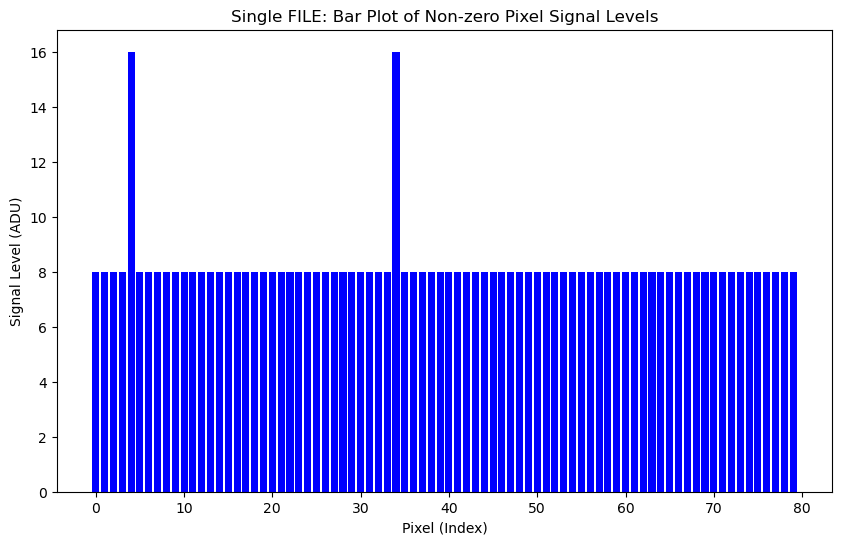

In [44]:
# Create a bar plot to visualize the signal levels for non-zero pixels
plt.figure(figsize=(10, 6))
plt.bar(pixel_indices, non_zero_signal_values, color='blue')
plt.title('Single FILE: Bar Plot of Non-zero Pixel Signal Levels')
plt.xlabel('Pixel (Index)')
plt.ylabel('Signal Level (ADU)')
plt.show()

### Single: Flatten Data

In [45]:
# Flatten the 2D image data into a 1D array
flattened_one_data = data.flatten()

In [46]:
# Confirm proper flattening
print(f"Shape of original data: {data.shape}")
print(f"Shape of flattened data: {flattened_one_data.shape}")

Shape of original data: (1080, 1440)
Shape of flattened data: (1555200,)


### Single File: Histrogram of Signal Levels

In [47]:
# Get the unique signal levels
unique_signal_levels = np.unique(flattened_one_data)
print(f"Unique signal levels: {unique_signal_levels}")

Unique signal levels: [ 0.  8. 16.]


In [48]:
# Create custom bin edges to match the unique signal levels for the histogram
# This ensures that each unique signal level gets its own bin
bin_edges = np.concatenate(([unique_signal_levels[0] - 0.5], 
                            (unique_signal_levels[:-1] + unique_signal_levels[1:]) / 2,
                            [unique_signal_levels[-1] + 0.5]))

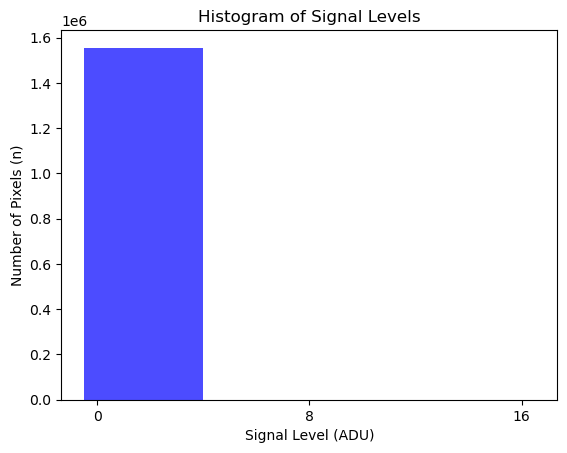

In [49]:
# Plot the histogram using the custom bins to visualize the distribution of signal levels
plt.figure()
plt.hist(flattened_one_data, bins=bin_edges, color='blue', alpha=0.7)
plt.title("Histogram of Signal Levels")
plt.xlabel("Signal Level (ADU)")
plt.ylabel("Number of Pixels (n)")
plt.xticks(unique_signal_levels)  # Set x-axis ticks to show only the unique values
plt.show()

### Multiple Files: Histogram of Non-zero Pixel Signal Levels

In [50]:
# Initialize an array to accumulate the sum of pixel values across files
sum_signal = None
num_files = len(fits_bias_files)  # Number of FITS files

In [51]:
# Loop through each FITS file and sum the pixel values
for fits_bias_file in fits_bias_files:
    with fits.open(fits_bias_file) as hdul:
        data = hdul[0].data  # Load the data from the FITS file

        if sum_signal is None:
            # Initialize sum_signal array with zeros, same shape as the data
            sum_signal = np.zeros_like(data)

        # Add current file's data to the cumulative sum
        sum_signal += data

In [52]:
# Calculate the mean signal level for each pixel by dividing by the number of files
mean_signal = sum_signal / num_files

# Select non-zero mean signal values for visualization
non_zero_signal_values = mean_signal[mean_signal != 0]

# Generate pixel indices for plotting (x-axis)
pixel_indices = np.arange(len(non_zero_signal_values))

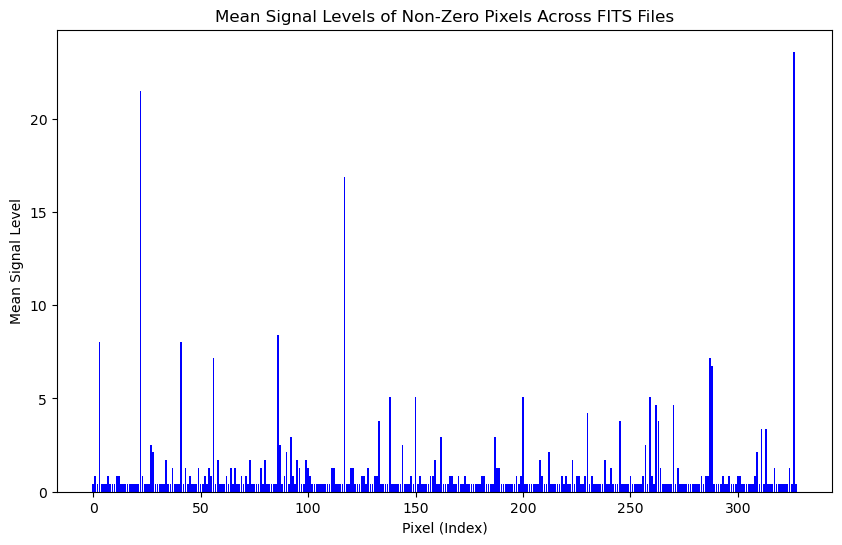

In [53]:
# Create a bar plot for the mean signal levels across all FITS files (non-zero pixels only)
plt.figure(figsize=(10, 6))
plt.bar(pixel_indices, non_zero_signal_values, color='blue')
plt.title('Mean Signal Levels of Non-Zero Pixels Across FITS Files')
plt.xlabel('Pixel (Index)')
plt.ylabel('Mean Signal Level')
plt.show()

### Multiple Files: Histrogram of Signal Levels

In [54]:
# Flatten the 2D mean signal array to a 1D array for histogram plotting
flattened_mean_signal = mean_signal.flatten()

In [55]:
# Get the unique signal levels in the flattened mean signal array
unique_mean_signal_levels = np.unique(flattened_mean_signal)
print(f"Unique mean signal levels: {unique_mean_signal_levels}")

Unique mean signal levels: [ 0.          0.42105263  0.84210526  1.26315789  1.68421053  2.10526316
  2.52631579  2.94736842  3.36842105  3.78947368  4.21052632  4.63157895
  5.05263158  6.73684211  7.15789474  8.          8.42105263 16.84210526
 21.47368421 23.57894737]


In [56]:
# Create custom bin edges to match the unique mean signal levels for the histogram
bin_edges_mean_signal = np.concatenate(([unique_mean_signal_levels[0] - 0.5], 
                                        (unique_mean_signal_levels[:-1] + unique_mean_signal_levels[1:]) / 2,
                                        [unique_mean_signal_levels[-1] + 0.5]))


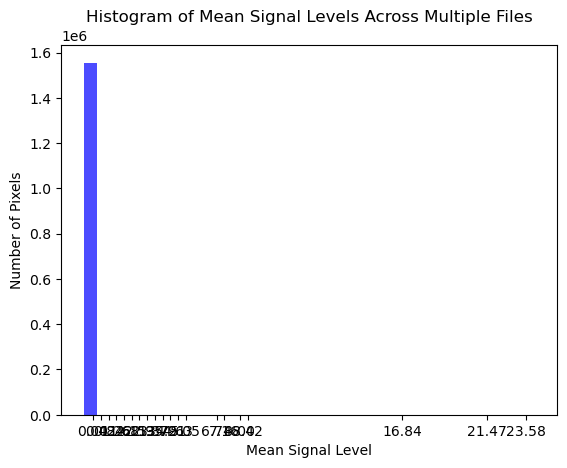

In [57]:
# Plot the histogram for the mean signal across all files
plt.figure()
plt.hist(flattened_mean_signal, bins=bin_edges_mean_signal, color='blue', alpha=0.7)
plt.title("Histogram of Mean Signal Levels Across Multiple Files")
plt.xlabel("Mean Signal Level")
plt.ylabel("Number of Pixels")
plt.xticks(unique_mean_signal_levels)  # Ensure the x-axis shows the unique values
plt.show()

### Print Bias Level Estimate from Dark Frames

In [58]:
# Calculate the overall bias level (average of the mean signals across all pixels)
bias_level = np.mean(mean_signal)


In [59]:
# Calculate the standard deviation of the mean signal across pixels (to quantify spread)
std_dev_signal = np.std(mean_signal)

In [60]:
# Calculate the error on the bias level (standard error of the mean)
# This gives an estimate of how much the mean signal is expected to vary
error_on_mean = std_dev_signal / np.sqrt(mean_signal.size)

In [61]:
# Print the calculated bias level and the error on the mean
print(f"Bias Level (mean signal): {bias_level}")
print(f"Error on Bias Level: {error_on_mean}")

Bias Level (mean signal): 0.0002325644357808102
Error on Bias Level: 2.932303192113708e-05


## 2.1.2 Dark Current Estimate from Multiple Dark Frames (long exposures)
*GOAL:* Collect a stack of dark frames with different exposure times. Examine the mean signal and the error on the mean signal to estimate the dark current. 
- Measure the signal as a function of exposure time (the slope of your line) and the uncertainty on that slope.
- Report this dark current level for your camera. 


### Setup

In [63]:
# DARK CURRENT: RAW and FITS directories (Trial 1)
raw_dark_current_1s_directory = "dark_current/trial1/1s/raw"
fits_dark_current_1s_directory = "dark_current/trial1/1s/fits"

raw_dark_current_5s_directory = "dark_current/trial1/5s/raw"
fits_dark_current_5s_directory = "dark_current/trial1/5s/fits"

raw_dark_current_10s_directory = "dark_current/trial1/10s/raw"
fits_dark_current_10s_directory = "dark_current/trial1/10s/fits"

raw_dark_current_15s_directory = "dark_current/trial1/15s/raw"
fits_dark_current_15s_directory = "dark_current/trial1/15s/fits"

raw_dark_current_20s_directory = "dark_current/trial1/20s/raw"
fits_dark_current_20s_directory = "dark_current/trial1/20s/fits"

raw_dark_current_25s_directory = "dark_current/trial1/25s/raw"
fits_dark_current_25s_directory = "dark_current/trial1/25s/fits"

raw_dark_current_30s_directory = "dark_current/trial1/30s/raw"
fits_dark_current_30s_directory = "dark_current/trial1/30s/fits"


In [64]:
# DARK CURRENT: RAW and FITS directories (Trial 2)
raw_dark_current_1s_directory2 = "dark_current/trial2/1s/raw"
fits_dark_current_1s_directory2 = "dark_current/trial2/1s/fits"

raw_dark_current_5s_directory2 = "dark_current/trial2/5s/raw"
fits_dark_current_5s_directory2 = "dark_current/trial2/5s/fits"

raw_dark_current_10s_directory2 = "dark_current/trial2/10s/raw"
fits_dark_current_10s_directory2 = "dark_current/trial2/10s/fits"

raw_dark_current_15s_directory2 = "dark_current/trial2/15s/raw"
fits_dark_current_15s_directory2 = "dark_current/trial2/15s/fits"

raw_dark_current_20s_directory2 = "dark_current/trial2/20s/raw"
fits_dark_current_20s_directory2 = "dark_current/trial2/20s/fits"

raw_dark_current_25s_directory2 = "dark_current/trial2/25s/raw"
fits_dark_current_25s_directory2 = "dark_current/trial2/25s/fits"

raw_dark_current_30s_directory2 = "dark_current/trial2/30s/raw"
fits_dark_current_30s_directory2 = "dark_current/trial2/30s/fits"



In [30]:
# DARK CURRENT: Convert RAW to FITS (Trial 1)
process_raw_to_fits(raw_directory=raw_dark_current_1s_directory,
                    fits_directory=fits_dark_current_1s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_dark_current_5s_directory,
                    fits_directory=fits_dark_current_5s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_dark_current_10s_directory,
                    fits_directory=fits_dark_current_10s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_dark_current_15s_directory,
                    fits_directory=fits_dark_current_15s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_dark_current_20s_directory,
                    fits_directory=fits_dark_current_20s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_dark_current_25s_directory,
                    fits_directory=fits_dark_current_25s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_dark_current_30s_directory,
                    fits_directory=fits_dark_current_30s_directory,
                    shape=(1080, 1440))



Found raw files:
 ['dark_current/trial1/1s/raw/dark_current1_1000000us.raw', 'dark_current/trial1/1s/raw/dark_current3_1000000us.raw', 'dark_current/trial1/1s/raw/dark_current2_1000000us.raw', 'dark_current/trial1/1s/raw/dark_current6_1000000us.raw', 'dark_current/trial1/1s/raw/dark_current5_1000000us.raw', 'dark_current/trial1/1s/raw/dark_current4_1000000us.raw']
Found output directory:
 dark_current/trial1/1s/fits
Moved dark_current/trial1/1s/raw/dark_current1_1000000us.fits to dark_current/trial1/1s/fits/dark_current1_1000000us.fits.

Moved dark_current/trial1/1s/raw/dark_current3_1000000us.fits to dark_current/trial1/1s/fits/dark_current3_1000000us.fits.

Moved dark_current/trial1/1s/raw/dark_current2_1000000us.fits to dark_current/trial1/1s/fits/dark_current2_1000000us.fits.

Moved dark_current/trial1/1s/raw/dark_current6_1000000us.fits to dark_current/trial1/1s/fits/dark_current6_1000000us.fits.

Moved dark_current/trial1/1s/raw/dark_current5_1000000us.fits to dark_current/trial1

In [77]:
# DARK CURRENT: Convert RAW to FITS (Trial 2)
process_raw_to_fits(raw_directory=raw_dark_current_1s_directory2,
                    fits_directory=fits_dark_current_1s_directory2,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_dark_current_5s_directory2,
                    fits_directory=fits_dark_current_5s_directory2,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_dark_current_10s_directory2,
                    fits_directory=fits_dark_current_10s_directory2,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_dark_current_15s_directory2,
                    fits_directory=fits_dark_current_15s_directory2,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_dark_current_20s_directory2,
                    fits_directory=fits_dark_current_20s_directory2,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_dark_current_25s_directory2,
                    fits_directory=fits_dark_current_25s_directory2,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_dark_current_30s_directory2,
                    fits_directory=fits_dark_current_30s_directory2,
                    shape=(1080, 1440))

Found raw files:
 ['dark_current/trial2/1s/raw/dark_current3_1000000us.raw', 'dark_current/trial2/1s/raw/dark_current4_1000000us.raw', 'dark_current/trial2/1s/raw/dark_current5_1000000us.raw', 'dark_current/trial2/1s/raw/dark_current1_1000000us.raw', 'dark_current/trial2/1s/raw/dark_current2_1000000us.raw', 'dark_current/trial2/1s/raw/dark_current6_1000000us.raw']
Found output directory:
 dark_current/trial2/1s/fits
Moved dark_current/trial2/1s/raw/dark_current3_1000000us.fits to dark_current/trial2/1s/fits/dark_current3_1000000us.fits.

Moved dark_current/trial2/1s/raw/dark_current4_1000000us.fits to dark_current/trial2/1s/fits/dark_current4_1000000us.fits.

Moved dark_current/trial2/1s/raw/dark_current5_1000000us.fits to dark_current/trial2/1s/fits/dark_current5_1000000us.fits.

Moved dark_current/trial2/1s/raw/dark_current1_1000000us.fits to dark_current/trial2/1s/fits/dark_current1_1000000us.fits.

Moved dark_current/trial2/1s/raw/dark_current2_1000000us.fits to dark_current/trial2

In [65]:
# List all FITS files for different exposure times
# This is done by globbing all .fits files in the respective directories
exposure_1000000us = glob.glob(os.path.join(fits_dark_current_1s_directory, "*.fits"))
exposure_5000000us = glob.glob(os.path.join(fits_dark_current_5s_directory, "*.fits"))
exposure_10000000us = glob.glob(os.path.join(fits_dark_current_10s_directory, "*.fits"))
exposure_15000000us = glob.glob(os.path.join(fits_dark_current_15s_directory, "*.fits"))
exposure_20000000us = glob.glob(os.path.join(fits_dark_current_20s_directory, "*.fits"))
exposure_25000000us = glob.glob(os.path.join(fits_dark_current_25s_directory, "*.fits"))
exposure_30000000us = glob.glob(os.path.join(fits_dark_current_30s_directory, "*.fits"))

exposure2_1000000us = glob.glob(os.path.join(fits_dark_current_1s_directory2, "*.fits"))
exposure2_5000000us = glob.glob(os.path.join(fits_dark_current_5s_directory2, "*.fits"))
exposure2_10000000us = glob.glob(os.path.join(fits_dark_current_10s_directory2, "*.fits"))
exposure2_15000000us = glob.glob(os.path.join(fits_dark_current_15s_directory2, "*.fits"))
exposure2_20000000us = glob.glob(os.path.join(fits_dark_current_20s_directory2, "*.fits"))
exposure2_25000000us = glob.glob(os.path.join(fits_dark_current_25s_directory2, "*.fits"))
exposure2_30000000us = glob.glob(os.path.join(fits_dark_current_30s_directory2, "*.fits"))


In [66]:
# Create a dictionary to map exposure times to the list of files for easier access
exposure_files_dict = {
    "exposure_1000000us": exposure_1000000us,
    "exposure_5000000us": exposure_5000000us,
    "exposure_10000000us": exposure_10000000us,
    "exposure_15000000us": exposure_15000000us,
    "exposure_20000000us": exposure_20000000us,
    "exposure_25000000us": exposure_25000000us,
    "exposure_30000000us": exposure_30000000us,
    "exposure2_1000000us": exposure2_1000000us,
    "exposure2_5000000us": exposure2_5000000us,
    "exposure2_10000000us": exposure2_10000000us,
    "exposure2_15000000us": exposure2_15000000us,
    "exposure2_20000000us": exposure2_20000000us,
    "exposure2_25000000us": exposure2_25000000us,
    "exposure2_30000000us": exposure2_30000000us,
}

### Plotting Mean Signal vs. Exposure Time

In [67]:
# Mean Signal Calculation Function
def calculate_mean_signal(filenames):
    """
    Calculate the mean signal from a set of FITS files.
    This function reads multiple files of the same exposure and calculates
    the average signal for the entire frame.
    """
    signals = []
    for filename in filenames:
        with fits.open(filename) as hdul:
            data = hdul[0].data  # Load the FITS file data
            signals.append(np.mean(data))  # Append the mean signal of the current frame
    return np.mean(signals)  # Return the average signal across all files


In [68]:
# Dark Current Processing Function
def process_dark_current(exposure_files_dict):
    """
    Process dark current data by calculating the mean signal for each exposure time.
    Perform linear regression to estimate the dark current (slope) and its uncertainty.
    """
    exposure_times = []  # To store the exposure times (in seconds)
    mean_signals = []    # To store the mean signal for each exposure time
    
    for key, files in exposure_files_dict.items():
        # Extract the numeric exposure time from the dictionary key (in microseconds)
        exposure_time_str = key.split('_')[1].replace('us', '')  # Extract the numeric part in us
        exposure_time = int(exposure_time_str) / 1e6  # Convert exposure time to seconds
        exposure_times.append(exposure_time)  # Append to the exposure time list
        
        # Calculate the mean signal for the given set of files
        mean_signal = calculate_mean_signal(files)
        mean_signals.append(mean_signal)  # Append the calculated mean signal
    
    # Convert exposure_times and mean_signals to numpy arrays for further processing
    exposure_times = np.array(exposure_times, dtype=np.float64)
    mean_signals = np.array(mean_signals, dtype=np.float64)

    # ## Linear Regression to Estimate Dark Current (Slope)
    
    # Perform linear regression to get the slope (dark current), intercept, and error values
    slope, intercept, r_value, p_value, std_err = linregress(exposure_times, mean_signals)

    # Return the results for further use (such as plotting or reporting)
    return exposure_times, mean_signals, slope, intercept, std_err


In [69]:
# Dark Current Calculation
# Process the dark current data using the function defined above
exposure_times, mean_signals, slope, intercept, std_err = process_dark_current(exposure_files_dict)


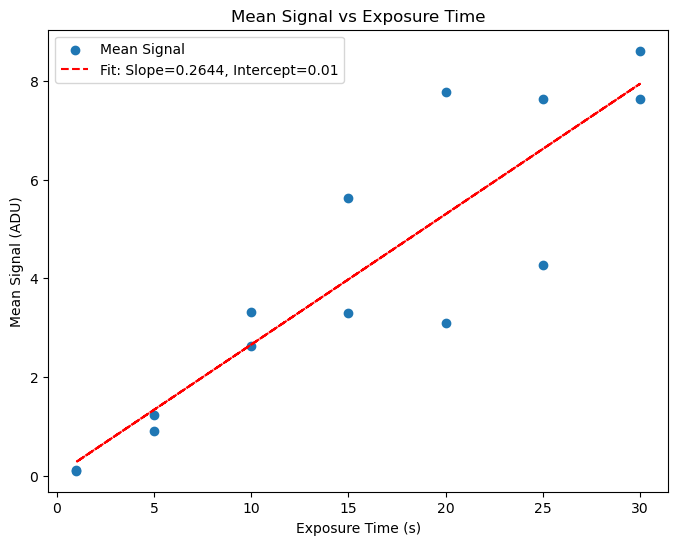

In [70]:
# Plot the Mean Signal vs Exposure Time

plt.figure(figsize=(8, 6))
plt.scatter(exposure_times, mean_signals, label="Mean Signal")  # Scatter plot of exposure time vs mean signal
plt.plot(exposure_times, intercept + slope * exposure_times, 'r--', 
         label=f"Fit: Slope={slope:.4f}, Intercept={intercept:.2f}")  # Plot the linear fit line
plt.xlabel("Exposure Time (s)")  # X-axis label
plt.ylabel("Mean Signal (ADU)")  # Y-axis label
plt.title("Mean Signal vs Exposure Time")  # Plot title
plt.legend()  # Show legend
plt.show()

### Print Dark Current Estimate from Dark Frames

In [71]:
# Print the estimated dark current (slope) and the uncertainty (standard error)
print(f"Dark Current (Slope): {np.round(slope, 4)} ADU/s")
print(f"Uncertainty in Dark Current (Slope): {np.round(std_err, 4)} ADU/s")

Dark Current (Slope): 0.2644 ADU/s
Uncertainty in Dark Current (Slope): 0.037 ADU/s


## 2.2 Read Noise Estimate from Multiple Flat Frames (short & long exposures)
*GOAL:* Measure images of a white light "flat frame" source at different intensities. Analyze a stack of flat frames to measure the read noise. 

### Setup

In [22]:
# READ NOISE: RAW and FITS directories
raw_readnoise_5us_directory = "readnoise/5us/raw"
fits_readnoise_5us_directory = "readnoise/5us/fits"

raw_readnoise_50us_directory = "readnoise/50us/raw"
fits_readnoise_50us_directory = "readnoise/50us/fits"

raw_readnoise_500us_directory = "readnoise/500us/raw"
fits_readnoise_500us_directory = "readnoise/500us/fits"

raw_readnoise_5000us_directory = "readnoise/500us/raw"
fits_readnoise_5000us_directory = "readnoise/500us/fits"

raw_readnoise_05s_directory = "readnoise/05s/raw"
fits_readnoise_05s_directory = "readnoise/05s/fits"

raw_readnoise_1s_directory = "readnoise/1s/raw"
fits_readnoise_1s_directory = "readnoise/1s/fits"

raw_readnoise_5s_directory = "readnoise/5s/raw"
fits_readnoise_5s_directory = "readnoise/5s/fits"

raw_readnoise_10s_directory = "readnoise/10s/raw"
fits_readnoise_10s_directory = "readnoise/10s/fits"

raw_readnoise_15s_directory = "readnoise/15s/raw"
fits_readnoise_15s_directory = "readnoise/15s/fits"

raw_readnoise_20s_directory = "readnoise/20s/raw"
fits_readnoise_20s_directory = "readnoise/20s/fits"

raw_readnoise_25s_directory = "readnoise/25s/raw"
fits_readnoise_25s_directory = "readnoise/25s/fits"

raw_readnoise_30s_directory = "readnoise/30s/raw"
fits_readnoise_30s_directory = "readnoise/30s/fits"

In [23]:
# READ NOISE: Convert RAW to FITS
process_raw_to_fits(raw_directory=raw_readnoise_5us_directory,
                    fits_directory=fits_readnoise_5us_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_readnoise_50us_directory,
                    fits_directory=fits_readnoise_50us_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_readnoise_500us_directory,
                    fits_directory=fits_readnoise_500us_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_readnoise_5000us_directory,
                    fits_directory=fits_readnoise_5000us_directory,
                    shape=(1080, 1440))


process_raw_to_fits(raw_directory=raw_readnoise_05s_directory,
                    fits_directory=fits_readnoise_05s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_readnoise_1s_directory,
                    fits_directory=fits_readnoise_1s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_readnoise_5s_directory,
                    fits_directory=fits_readnoise_5s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_readnoise_10s_directory,
                    fits_directory=fits_readnoise_10s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_readnoise_15s_directory,
                    fits_directory=fits_readnoise_15s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_readnoise_20s_directory,
                    fits_directory=fits_readnoise_20s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_readnoise_25s_directory,
                    fits_directory=fits_readnoise_25s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_readnoise_30s_directory,
                    fits_directory=fits_readnoise_30s_directory,
                    shape=(1080, 1440))


Found raw files:
 ['readnoise/5us/raw/readnoise4_5us.raw', 'readnoise/5us/raw/readnoise3_5us.raw', 'readnoise/5us/raw/readnoise2_5us.raw', 'readnoise/5us/raw/readnoise1_5us.raw', 'readnoise/5us/raw/readnoise6_5us.raw', 'readnoise/5us/raw/readnoise5_5us.raw']
Found output directory:
 readnoise/5us/fits
Moved readnoise/5us/raw/readnoise4_5us.fits to readnoise/5us/fits/readnoise4_5us.fits.

Moved readnoise/5us/raw/readnoise3_5us.fits to readnoise/5us/fits/readnoise3_5us.fits.

Moved readnoise/5us/raw/readnoise2_5us.fits to readnoise/5us/fits/readnoise2_5us.fits.

Moved readnoise/5us/raw/readnoise1_5us.fits to readnoise/5us/fits/readnoise1_5us.fits.

Moved readnoise/5us/raw/readnoise6_5us.fits to readnoise/5us/fits/readnoise6_5us.fits.

Moved readnoise/5us/raw/readnoise5_5us.fits to readnoise/5us/fits/readnoise5_5us.fits.

Found raw files:
 ['readnoise/50us/raw/readnoise1_50us.raw', 'readnoise/50us/raw/readnoise2_50us.raw', 'readnoise/50us/raw/readnoise3_50us.raw', 'readnoise/50us/raw/read

In [24]:
# List all FITS files for different exposure times
flat_5us = glob.glob(os.path.join(fits_readnoise_5us_directory, "*.fits"))
flat_50us = glob.glob(os.path.join(fits_readnoise_50us_directory, "*.fits"))
flat_500us = glob.glob(os.path.join(fits_readnoise_500us_directory, "*.fits"))
flat_5000us = glob.glob(os.path.join(fits_readnoise_5000us_directory, "*.fits"))
flat_500000us = glob.glob(os.path.join(fits_readnoise_05s_directory, "*.fits"))
flat_1000000us = glob.glob(os.path.join(fits_readnoise_1s_directory, "*.fits"))
flat_5000000us = glob.glob(os.path.join(fits_readnoise_5s_directory, "*.fits"))                        
flat_10000000us = glob.glob(os.path.join(fits_readnoise_10s_directory, "*.fits"))                        
flat_15000000us = glob.glob(os.path.join(fits_readnoise_15s_directory, "*.fits"))                       
flat_20000000us = glob.glob(os.path.join(fits_readnoise_20s_directory, "*.fits"))                        
flat_25000000us = glob.glob(os.path.join(fits_readnoise_25s_directory, "*.fits"))                        
flat_30000000us = glob.glob(os.path.join(fits_readnoise_30s_directory, "*.fits"))                        


In [26]:
# Create a dictionary to map exposure times to the list of files for easier access
flat_files_dict = {
    "500000us": flat_500000us,
    "1000000us": flat_1000000us,
    "5000000us": flat_5000000us,
    "10000000us": flat_10000000us,
    "15000000us": flat_15000000us,
    "20000000us": flat_20000000us,
    "25000000us": flat_25000000us,
    "30000000us": flat_30000000us,
}


In [27]:
# Create a dictionary for only short exposure times

flat_files_dict_new = {
    "5us": flat_5us,
    "50us": flat_50us,
    "500us": flat_500us,
    "5000us": flat_5000us,
}

In [29]:
with fits.open('readnoise/500us/fits/readnoise5_500us.fits') as hdul:
    data = hdul[0].data
    print(data)

[[4088. 4088. 4088. ... 4088. 4088. 4088.]
 [4088. 4088. 4088. ... 4088. 4088. 4088.]
 [4088. 4088. 4088. ... 4088. 4088. 4088.]
 ...
 [4088. 4088. 4088. ... 4088. 4088. 4088.]
 [4088. 4088. 4088. ... 4088. 4088. 4088.]
 [4088. 4088. 4088. ... 4088. 4088. 4088.]]


In [22]:
# Store mean signal levels and noise (standard deviation) for each exposure time
mean_signals = []
noise_values = []
exposure_times = []
rms_errors = []
read_noise = None  # To store the estimated read noise


### Load Flat Frames for Each Exposure Time

In [23]:
def load_flat_frames(files):
    """
    Load a stack of flat frames from a list of FITS files.
    This function reads the data from each FITS file and returns a numpy array of frames.
    """
    frames = []
    for file in files:
        with fits.open(file) as hdul:
            data = hdul[0].data  # Extract the image data
            frames.append(data)   # Append the image data to the list
    return np.array(frames)  # Convert the list of frames to a numpy array


### Process the Flat Frames (ALL)

Processing exposure time: 500000us


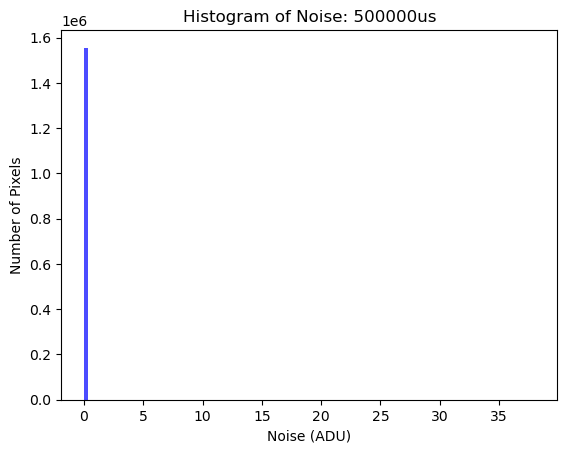

Processing exposure time: 1000000us


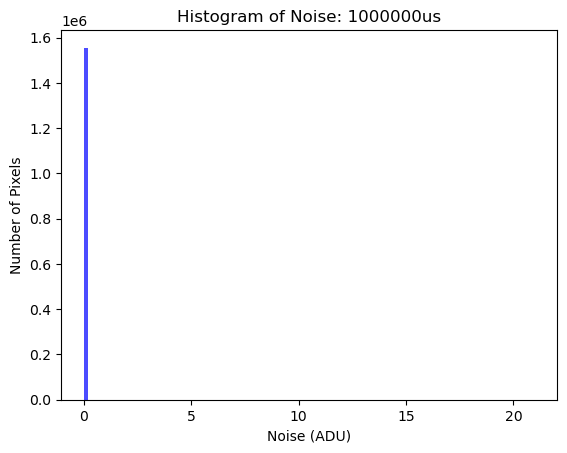

Processing exposure time: 5000000us
No data found for exposure time 5000000us. Skipping.
Processing exposure time: 10000000us


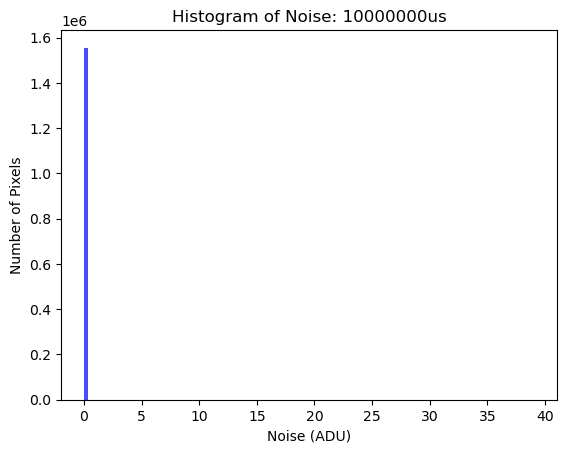

Processing exposure time: 15000000us


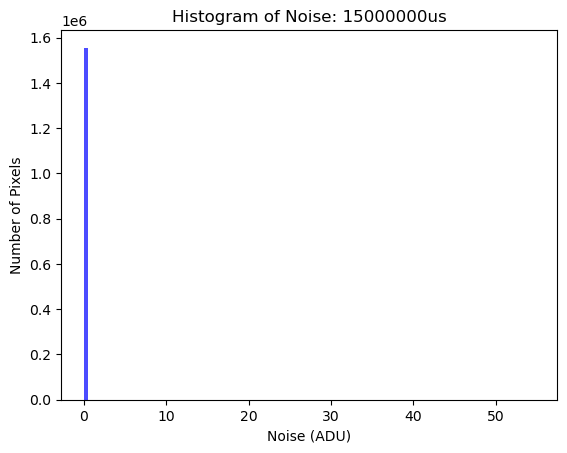

Processing exposure time: 20000000us


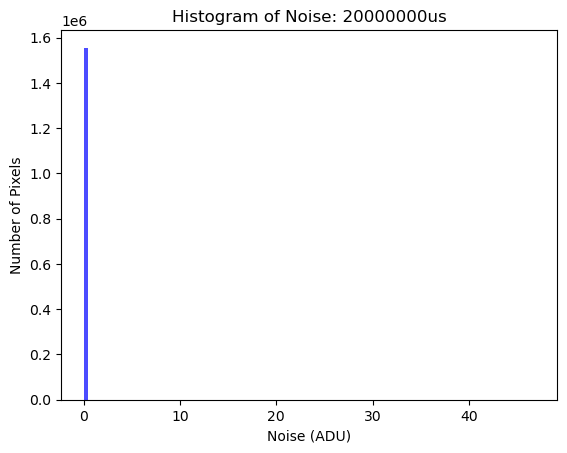

Processing exposure time: 25000000us


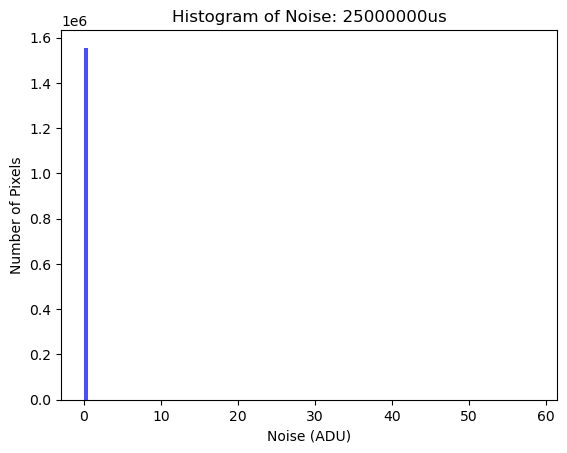

Processing exposure time: 30000000us


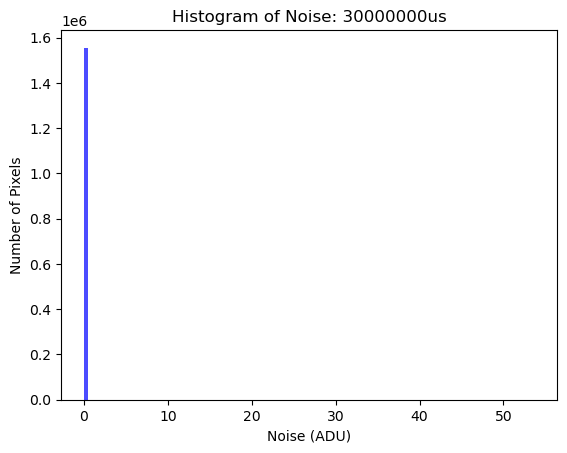

In [24]:
for exposure_time, flat_files in flat_files_dict.items():
    print(f"Processing exposure time: {exposure_time}")

    # Load the stack of flat frames for the current exposure time
    flat_frames_stack = load_flat_frames(flat_files)

    # Skip if no data is available for the current exposure time
    if flat_frames_stack.size == 0:
        print(f"No data found for exposure time {exposure_time}. Skipping.")
        continue

    # ## Mean Frame and Residual Noise Calculation

    # Calculate the mean frame across the stack (average pixel value for each pixel)
    mean_frame = np.mean(flat_frames_stack, axis=0)

    # Subtract the mean frame from each individual frame to obtain the residuals
    residuals = flat_frames_stack - mean_frame

    # Calculate the standard deviation (RMS noise) for each pixel across the stack
    std_frame = np.std(residuals, axis=0)

    # Calculate the overall mean signal and noise for this exposure time
    mean_signal = np.mean(mean_frame)
    noise = np.mean(std_frame)
    
    # Append the calculated mean signal and noise values to their respective lists
    mean_signals.append(mean_signal)
    noise_values.append(noise)
    exposure_times.append(int(exposure_time.replace("us", "")))  # Convert exposure time to integer for plotting

    # ## Estimate Read Noise from the Shortest Exposure Time

    if exposure_time == "5us":
        read_noise = noise  # The noise from the shortest exposure is assumed to be dominated by read noise
        print(f"Read noise estimated from {exposure_time}: {read_noise} ADU")

    # ## Histogram of Noise for Current Exposure Time

    # Plot a histogram of the noise (standard deviation) for the current exposure time
    plt.figure()
    plt.hist(std_frame.flatten(), bins=100, color='blue', alpha=0.7)
    plt.title(f'Histogram of Noise: {exposure_time}')
    plt.xlabel('Noise (ADU)')
    plt.ylabel('Number of Pixels')
    plt.show()

### Plot Noise vs Exposure Time (ALL)

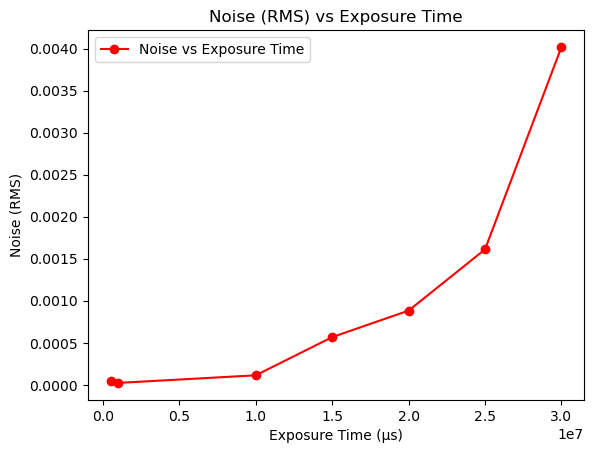

In [25]:
# Plot Noise vs Exposure Time
plt.figure()
plt.plot(exposure_times, noise_values, 'o-', color='red', label='Noise vs Exposure Time')
plt.title('Noise (RMS) vs Exposure Time')
plt.xlabel('Exposure Time (µs)')
plt.ylabel('Noise (RMS)')
plt.legend()
plt.show()

In [26]:
# Store mean signal levels and noise (standard deviation) for each exposure time
mean_signals_short = []
noise_values_short = []
exposure_times_short = []
rms_errors_short = []
read_noise_short = None  # To store the estimated read noise

Processing exposure time: 5us
Read noise estimated from 5us: None ADU


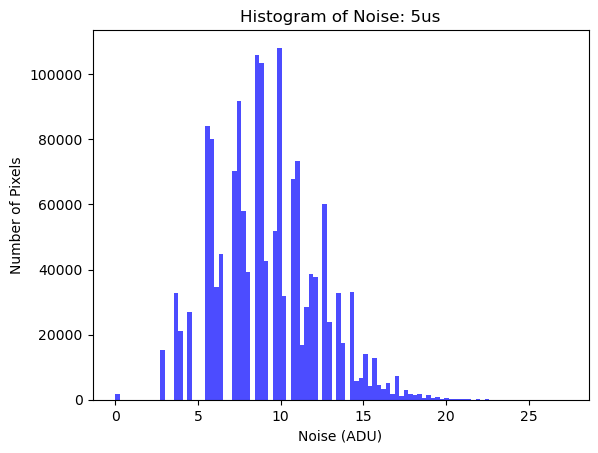

Processing exposure time: 50us


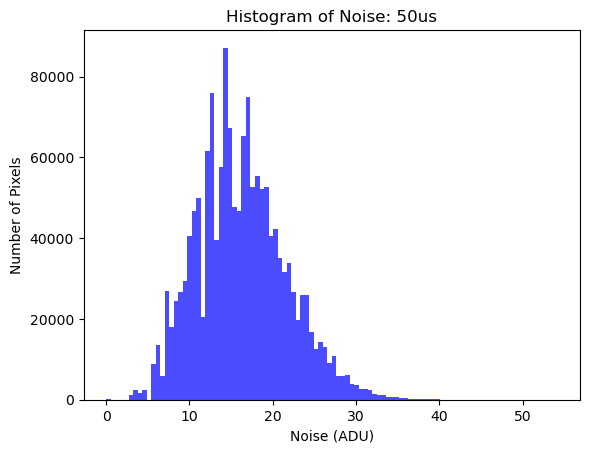

Processing exposure time: 500us


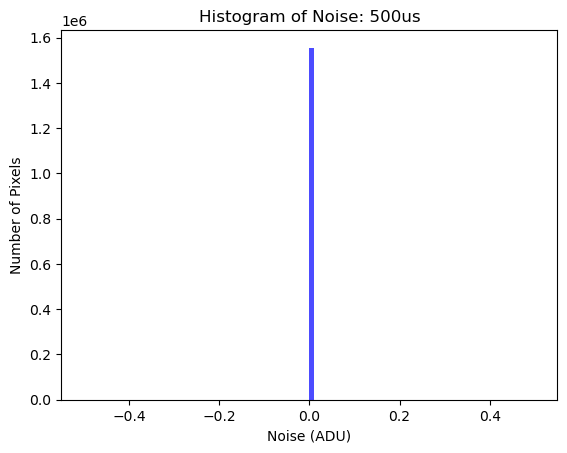

Processing exposure time: 5000us


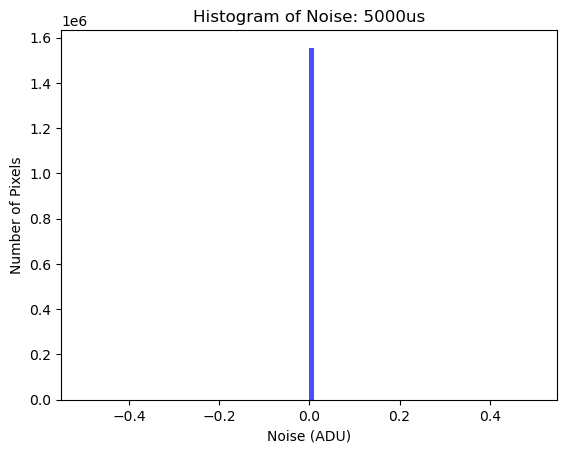

In [27]:
for exposure_time, flat_files in flat_files_dict_new.items():
    print(f"Processing exposure time: {exposure_time}")

    # Load the stack of flat frames for the current exposure time
    flat_frames_stack = load_flat_frames(flat_files)

    # Skip if no data is available for the current exposure time
    if flat_frames_stack.size == 0:
        print(f"No data found for exposure time {exposure_time}. Skipping.")
        continue

    # ## Mean Frame and Residual Noise Calculation

    # Calculate the mean frame across the stack (average pixel value for each pixel)
    mean_frame = np.mean(flat_frames_stack, axis=0)

    # Subtract the mean frame from each individual frame to obtain the residuals
    residuals = flat_frames_stack - mean_frame

    # Calculate the standard deviation (RMS noise) for each pixel across the stack
    std_frame = np.std(residuals, axis=0)

    # Calculate the overall mean signal and noise for this exposure time
    mean_signal = np.mean(mean_frame)
    noise = np.mean(std_frame)
    
    # Append the calculated mean signal and noise values to their respective lists
    mean_signals_short.append(mean_signal)
    noise_values_short.append(noise)
    exposure_times_short.append(int(exposure_time.replace("us", "")))  # Convert exposure time to integer for plotting

    # ## Estimate Read Noise from the Shortest Exposure Time

    if exposure_time == "5us":
        read_noise_short = noise  # The noise from the shortest exposure is assumed to be dominated by read noise
        print(f"Read noise estimated from {exposure_time}: {read_noise} ADU")

    # ## Histogram of Noise for Current Exposure Time

    # Plot a histogram of the noise (standard deviation) for the current exposure time
    plt.figure()
    plt.hist(std_frame.flatten(), bins=100, color='blue', alpha=0.7)
    plt.title(f'Histogram of Noise: {exposure_time}')
    plt.xlabel('Noise (ADU)')
    plt.ylabel('Number of Pixels')
    plt.show()

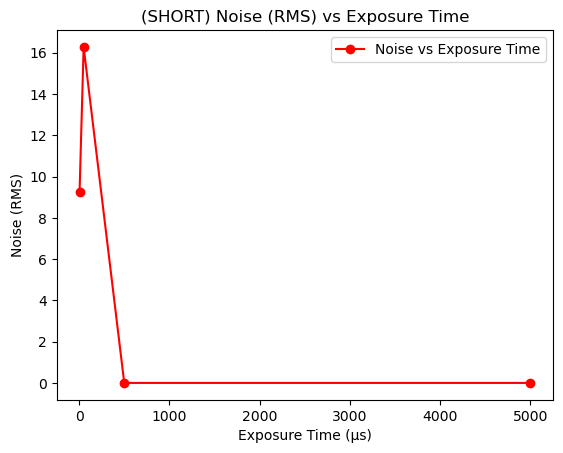

In [28]:
# Plot Noise vs Exposure Time
plt.figure()
plt.plot(exposure_times_short, noise_values_short, 'o-', color='red', label='Noise vs Exposure Time')
plt.title('(SHORT) Noise (RMS) vs Exposure Time')
plt.xlabel('Exposure Time (µs)')
plt.ylabel('Noise (RMS)')
plt.legend()
plt.show()

### Analyzing Read Noise for Short Exposure Times

In [29]:
for exposure_time, flat_files in flat_files_dict_new.items():
    print(f"Processing exposure time: {exposure_time}")

    # Load the stack of flat frames for the current exposure time
    flat_frames_stack = load_flat_frames(flat_files)

    # Skip if no data is available for the current exposure time
    if flat_frames_stack.size == 0:
        print(f"No data found for exposure time {exposure_time}. Skipping.")
        continue

    # ## Mean Frame and Residual Noise Calculation

    # Calculate the mean frame across the stack (average pixel value for each pixel)
    mean_frame = np.mean(flat_frames_stack, axis=0)

    # Subtract the mean frame from each individual frame to obtain the residuals
    residuals = flat_frames_stack - mean_frame

    # Calculate the standard deviation (RMS noise) for each pixel across the stack
    std_frame = np.std(residuals, axis=0)

    # Calculate the overall RMS error for this exposure time
    rms_error = np.sqrt(np.mean(std_frame**2))  # Root-mean-square error for the current exposure
    rms_errors.append(rms_error)  # Append the RMS error to the list

    # Print the RMS error for the current exposure time
    print(f"RMS error for {exposure_time}: {rms_error} ADU")

Processing exposure time: 5us
RMS error for 5us: 9.763622200433288 ADU
Processing exposure time: 50us
RMS error for 50us: 17.15297641543737 ADU
Processing exposure time: 500us
RMS error for 500us: 0.0 ADU
Processing exposure time: 5000us
RMS error for 5000us: 0.0 ADU


### Print Read Noise Estimate from Dark Frames

In [31]:
# Calculate and Print the Combined RMS Error for All Exposure Times

read_noise_error = np.sqrt(np.mean(np.array(rms_errors)**2))
print(f"Combined RMS error across 5us, 50us, 500us, and 5000us: {np.round(read_noise_error,4)} ADU")


Combined RMS error across 5us, 50us, 500us, and 5000us: 9.8685 ADU


# Astronomical Measurements

**KEY STEPS:** 
- **Measure the flux and flux uncertainty of Jupiter-sim’s red spot.**
- **Determine the signal-to-noise ratio on Jupiter-sim’s red spot in a 1 second integration.**
  - **To complete this step, you will need to understand the noise characteristics of your detector.**
  - **How did you convert the observed signal from the detector into flux?**

\
Detectors have multiple sources of noise that affect the signal. Noise from independent sources add in **quadrature**, so we add the squares of each noise source and then take the square root of them to get the total noise.   \
\
**Important Variables:**
- **S** = signal level, total signal from the object we are observing summed over $n$ pixels (light in electrons coming from object)
- **N** = noise, total noise from various sources (readout noise, photon noise, etc)
- **u_r** = **bias** (residual noise), average across $n$ pixels
- **D** = **dark current**, noise generated in absence of light
- **R^2** = **readout noise**, squared
- **B** = sky background, coming from sky not background
- **T** = total integration time, exposure time multipled by number of object frames $n_0$
- **f** = ratio of object signal to the background signal per pixel
- **t** = exposure time
- **\epsilon_D** = ratio of number of object frames to dark frames
- **\epsilon_B** = ratio of number of object frames to sky background

*Signal-to-noise Ratio Equation* where we define $S$ as the total object signal summed over $n$ pixels ($S = \sum(S_i)$)

$$
\frac{S}{N} = S\sqrt{T}\left[\left(B + D + \frac{R^2}{t} + \epsilon_D\left(D + \frac{R^2}{t} \right) + (1+f)^2\epsilon_B\left(B + D + \frac{R^2}{t} \right) + (1+f)^2\epsilon_D\left(D + \frac{R^2}{t} \right) \right) \right]^{-\frac{1}{2}}
$$

Where $g$ is the transfer factor of electrons/DN, $T = tn_0$ is the TOTAL integration time accumulated on the OBJECT FRAMES; $f$ is the ratio of the source signal to that of the "background"signal per pixel, $\epsilon_B = \frac{n_0}{n_B}$ is the ratio of the number of object frames to background frames, $\epsilon_D = \frac{n_0}{n_D}$ is the ratio of the number of object to dark-current frames, $u_r$ is the average over $n$ pixels of any residual.  


## 3.2 Astrometry
*GOAL:* Measure the position and positional uncertainty of a star in the globular cluster-sim.

In [23]:
# READ NOISE: RAW and FITS directories
raw_star1_directory = "star/trial1/raw"
fits_star2_directory = "star/trial1/fits"


In [27]:
# READ NOISE: Convert RAW to FITS
process_raw_to_fits(raw_directory=raw_star1_directory,
                    fits_directory=fits_star2_directory,
                    shape=(1080, 1440))

Found raw files:
 ['star/trial1/raw/star3_1000us.raw', 'star/trial1/raw/star1_1000us.raw', 'star/trial1/raw/star2_1000us.raw', 'star/trial1/raw/star4_1000us.raw', 'star/trial1/raw/star5_1000us.raw', 'star/trial1/raw/star6_1000us.raw']
Found output directory:
 star/trial1/fits
Moved star/trial1/raw/star3_1000us.fits to star/trial1/fits/star3_1000us.fits.

Moved star/trial1/raw/star1_1000us.fits to star/trial1/fits/star1_1000us.fits.

Moved star/trial1/raw/star2_1000us.fits to star/trial1/fits/star2_1000us.fits.

Moved star/trial1/raw/star4_1000us.fits to star/trial1/fits/star4_1000us.fits.

Moved star/trial1/raw/star5_1000us.fits to star/trial1/fits/star5_1000us.fits.

Moved star/trial1/raw/star6_1000us.fits to star/trial1/fits/star6_1000us.fits.



In [28]:
fits_files_star1 = glob.glob(os.path.join(fits_star2_directory, "*.fits"))

In [30]:
# 2D Gaussian function
def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = xy
    a = (np.cos(theta)**2) / (2*sigma_x**2) + (np.sin(theta)**2) / (2*sigma_y**2)
    b = -(np.sin(2*theta)) / (4*sigma_x**2) + (np.sin(2*theta)) / (4*sigma_y**2)
    c = (np.sin(theta)**2) / (2*sigma_x**2) + (np.cos(theta)**2) / (2*sigma_y**2)
    return offset + amplitude * np.exp(-(a * (x - x0)**2 + 2 * b * (x - x0) * (y - y0) + c * (y - y0)**2))


In [31]:
# FWHM calculation from sigma
def fwhm_from_sigma(sigma):
    return 2.355 * sigma


In [32]:
# Fitting Gaussian to a region
def fit_star_gaussian(data, x_guess, y_guess, size=10):
    # Create a small cutout around the star
    x_min, x_max = int(x_guess - size), int(x_guess + size)
    y_min, y_max = int(y_guess - size), int(y_guess + size)
    data_cutout = data[y_min:y_max, x_min:x_max]
    
    # Coordinates grid
    x = np.arange(x_min, x_max)
    y = np.arange(y_min, y_max)
    x, y = np.meshgrid(x, y)
    
    # Initial guesses for fitting
    initial_guess = (data_cutout.max(), x_guess, y_guess, 1, 1, 0, np.median(data_cutout))
    
    # Fit Gaussian
    try:
        popt, _ = curve_fit(gaussian_2d, (x, y), data_cutout.ravel(), p0=initial_guess)
    except RuntimeError as e:
        print(f"Error fitting Gaussian: {e}")
        return None
    
    return popt


In [35]:
x_center = 490
y_center = 300

In [36]:
gaussian_parameters = []

In [37]:
# Process all FITS files
for file in fits_files_star1:
    with fits.open(file) as hdul:
        data = hdul[0].data

        # Fit Gaussian to the star
        params = fit_star_gaussian(data, x_center, y_center)
        if params:
            gaussian_parameters.append(params)


ValueError: operands could not be broadcast together with shapes (20,20) (400,) 

## 3.1 Photometry
*GOAL:* Measure the flux and flux uncertainty of Jupiter-sim’s red spot. Determine the signal-to-noise ratio on Jupiter-sim’s red spot in a 1 second integration.

### Setup

In [124]:
# Exposure time in microseconds (us)
exposure_time = 1000  # Placeholder value for noise


In [111]:
# Directories for RAW and FITS data of different exposures
raw_red_spot_05s_directory = "red_spot/05s/raw"
fits_red_spot_05s_directory = "red_spot/05s/fits"

raw_red_spot_1s_directory = "red_spot/1s/raw"
fits_red_spot_1s_directory = "red_spot/1s/fits"

raw_red_spot_2s_directory = "red_spot/2s/raw"
fits_red_spot_2s_directory = "red_spot/2s/fits"


In [125]:
# Convert RAW data to FITS format for further analysis
process_raw_to_fits(raw_directory=raw_red_spot_05s_directory,
                    fits_directory=fits_red_spot_05s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_red_spot_1s_directory,
                    fits_directory=fits_red_spot_1s_directory,
                    shape=(1080, 1440))

process_raw_to_fits(raw_directory=raw_red_spot_2s_directory,
                    fits_directory=fits_red_spot_2s_directory,
                    shape=(1080, 1440))


Found raw files:
 ['red_spot/05s/raw/red_spot1_500000us.raw', 'red_spot/05s/raw/red_spot3_500000us.raw', 'red_spot/05s/raw/red_spot4_500000us.raw', 'red_spot/05s/raw/red_spot5_500000us.raw', 'red_spot/05s/raw/red_spot6_500000us.raw', 'red_spot/05s/raw/red_spot2_500000us.raw']
Found output directory:
 red_spot/05s/fits
Moved red_spot/05s/raw/red_spot1_500000us.fits to red_spot/05s/fits/red_spot1_500000us.fits.

Moved red_spot/05s/raw/red_spot3_500000us.fits to red_spot/05s/fits/red_spot3_500000us.fits.

Moved red_spot/05s/raw/red_spot4_500000us.fits to red_spot/05s/fits/red_spot4_500000us.fits.

Moved red_spot/05s/raw/red_spot5_500000us.fits to red_spot/05s/fits/red_spot5_500000us.fits.

Moved red_spot/05s/raw/red_spot6_500000us.fits to red_spot/05s/fits/red_spot6_500000us.fits.

Moved red_spot/05s/raw/red_spot2_500000us.fits to red_spot/05s/fits/red_spot2_500000us.fits.

Found raw files:
 ['red_spot/1s/raw/red_spot1_1000000us.raw', 'red_spot/1s/raw/red_spot2_1000000us.raw', 'red_spot/1

In [126]:
# FITS files for different exposure times
red_spot_500000us_file = "red_spot/05s/fits/red_spot1_500000us.fits"
red_spot_1000000us_file = "red_spot/1s/fits/red_spot1_1000000us.fits"
red_spot_2000000us_file = "red_spot/2s/fits/red_spot1_2000000us.fits"


In [127]:
# Assuming a standard frame shape of 1080 x 1440 pixels
frame_shape = (1080, 1440)

### Creating the Bias Frame

In [128]:
# Create a bias frame (a constant value across the frame)
def create_bias_frame(bias_level, frame_shape):
    """
    Creates a bias frame with a constant bias level across all pixels.
    """
    
    bias_frame = np.full(frame_shape, bias_level)
    print(f"Bias Frame Created: Bias level set to {bias_level} ADU per pixel.")
    return bias_frame

### Creating the Dark Current Frame

In [129]:
# Generate a dark frame based on the dark current slope and exposure time
def create_dark_frame(slope, exposure_time, frame_shape):
    """
    Creates a dark frame based on dark current slope and exposure time.
    Dark current accumulates linearly with exposure.
    """
    
    dark_frame = slope * exposure_time
    print(f"Dark Frame Created: slope = {slope} ADU/us, exposure = {exposure_time} us.")
    return np.full(frame_shape, dark_frame)

### Creating the Flat Frame

In [130]:
# Create a flat frame with random variations, and subtract bias/dark frames
def create_flat_frame(bias_frame, dark_frame, combined_rms_error, frame_shape):
    """
    Creates a flat frame with small pixel-to-pixel variations, 
    subtracts bias and dark frames, and normalizes the result.
    """
    
    flat_frame = np.ones(frame_shape) + np.random.normal(0, combined_rms_error, frame_shape)
    print(f"Flat Frame Created: RMS error set to {combined_rms_error}.")
    
    # Normalize the flat frame after subtracting bias and dark contributions
    normalized_flat_frame = (flat_frame - bias_frame - dark_frame) / np.median(flat_frame - bias_frame - dark_frame)
    print("Flat Frame Normalized.")
    return normalized_flat_frame
    

### Clean function

In [131]:
# Clean an object frame by subtracting bias, dark, and correcting with flat frame
def clean_frame(object_frame, bias_frame, dark_frame, normalized_flat_frame):
    """
    Cleans an object frame by subtracting bias and dark frames, 
    and dividing by the normalized flat frame to correct pixel variations.
    """
    
    cleaned_frame = (object_frame - bias_frame - dark_frame) / normalized_flat_frame
    print("Frame successfully cleaned.")
    return cleaned_frame

### Load the Red Spot Images and Clean Them (for specific files)

In [132]:
# Function to load and clean red spot image, display raw and cleaned image
def load_and_clean_red_spot_image(file_path, bias_frame, dark_frame, flat_frame, is_fits=True):
    """
    Loads an image file (FITS or RAW), displays the raw image, 
    cleans the image by subtracting bias, dark, and correcting with flat, 
    then displays the cleaned image.
    """
    if is_fits:
        with fits.open(file_path) as hdul:
            data = hdul[0].data
            print(f"Loaded FITS file: {file_path}")
    else:
        data = np.fromfile(file_path, dtype='uint16').reshape(1080, 1440)
        print(f"Loaded RAW file: {file_path}")

    # Display raw image
    plt.imshow(data, cmap='gray')
    plt.title(f"Raw Image: {file_path}")
    plt.colorbar()
    plt.show()

    # Clean the raw data
    cleaned_data = clean_frame(data, bias_frame, dark_frame, flat_frame)

    # Display cleaned image
    plt.imshow(cleaned_data, cmap='gray')
    plt.title(f"Cleaned Image: {file_path}")
    plt.colorbar()
    plt.show()

    return cleaned_data

In [133]:
# Generate frames based on given bias level, slope, and RMS error
bias_frame = create_bias_frame(bias_level, frame_shape)
dark_frame = create_dark_frame(slope, exposure_time, frame_shape)
flat_frame = create_flat_frame(bias_frame, dark_frame, combined_rms_error, frame_shape)


Bias Frame Created: Bias level set to 0.00022748056698673974 ADU per pixel.
Dark Frame Created: slope = 0.26670843546181205 ADU/us, exposure = 1000 us.
Flat Frame Created: RMS error set to 9.868547491669485.
Flat Frame Normalized.


Processing red_spot1_500000us.fits...
Loaded FITS file: red_spot/05s/fits/red_spot1_500000us.fits


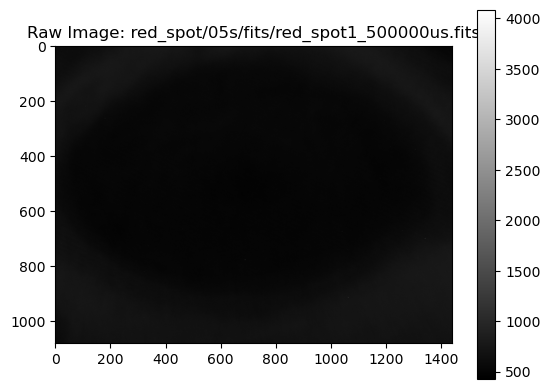

Frame successfully cleaned.


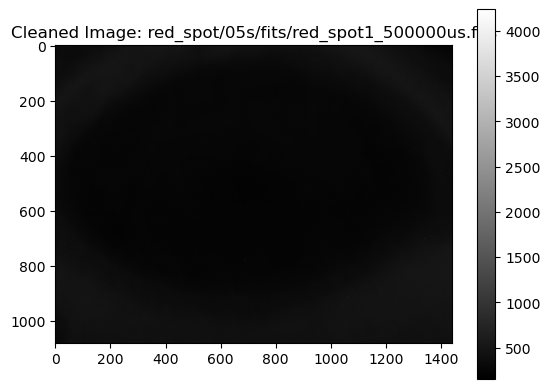

Processing red_spot1_1000000us.fits...
Loaded FITS file: red_spot/1s/fits/red_spot1_1000000us.fits


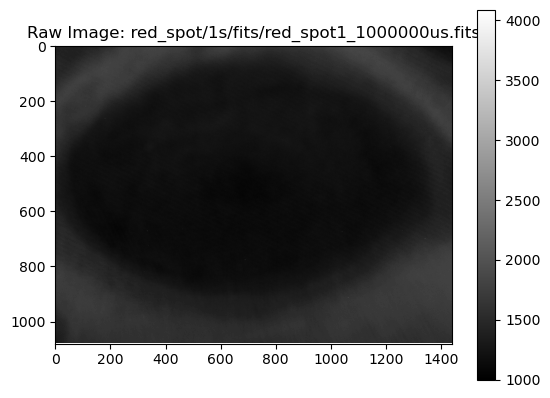

Frame successfully cleaned.


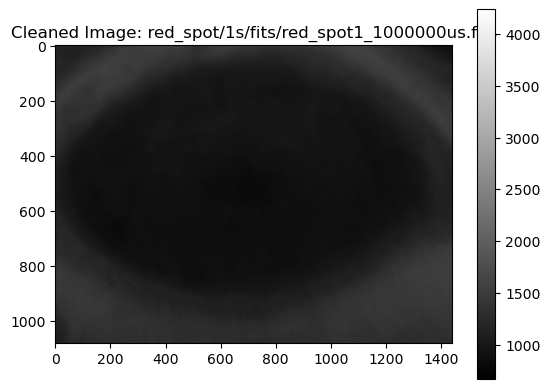

array([[1174.90332577, 1208.4960214 , 1214.50096226, ...,  924.50275515,
         860.70394312,  889.70130889],
       [1305.6589124 , 1143.95423944, 1138.48204125, ...,  901.93337429,
         864.50791131,  852.62113994],
       [1139.14162557, 1163.72600997, 1251.16584501, ...,  840.74545368,
         849.02312443,  945.30680967],
       ...,
       [1062.74774278, 1059.68193364, 1114.34585494, ..., 1245.03473114,
        1293.02901244, 1303.77912424],
       [1036.67115745, 1052.20160815, 1070.02036862, ..., 1347.14859546,
        1270.28779712, 1289.59170538],
       [1081.63041742, 1110.78266872, 1015.45881788, ..., 1221.94771834,
        1254.56466607, 1232.11269947]])

In [134]:
# Process specific red spot images
print("Processing red_spot1_500000us.fits...")
load_and_clean_red_spot_image(red_spot_500000us_file, bias_frame, dark_frame, flat_frame)

print("Processing red_spot1_1000000us.fits...")
load_and_clean_red_spot_image(red_spot_1000000us_file, bias_frame, dark_frame, flat_frame)


## 3.2 Astrometry

*GOAL:* Measure the position and positional uncertainty of a star in the globular cluster-sim. 

In [11]:
# Load a specific star image 
star_image_filepath = "star/trial1/fits/star1_1000us.fits"
star_image = fits.getdata(star_image_filepath)

In [12]:
# Display the entire star image to identify coordinates
def show_entire_star_image(image):
    plt.figure(figsize=(4, 4))
    norm = plt.imshow(image, cmap='gray', origin='lower')
    plt.title("Star Data as an Image")
    plt.colorbar()
    plt.show()

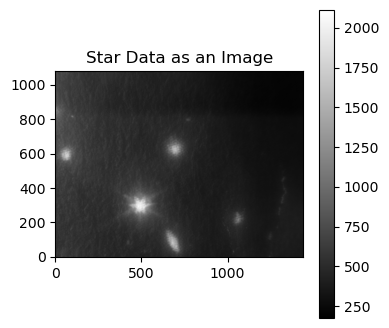

In [13]:
# Show the entire star image
show_entire_star_image(star_image)

In [16]:
# Plot the image with a box around it
def plot_image_with_box(image, x, y, box_size):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image, cmap='gray', origin='lower')

    # Define the box and add it to the plot
    box = patches.Rectangle((x - box_size / 2, y - box_size / 2), box_size, box_size, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(box)
    
    #plt.colorbar()
    plt.title(f"Image with Box (Center: {x}, {y}, Size: {box_size})")
    plt.show()

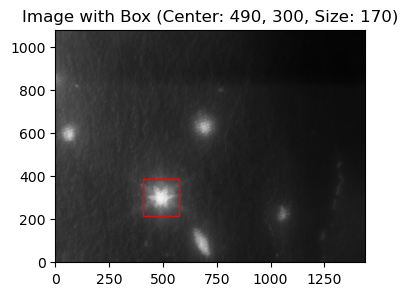

In [18]:
star_x = 490
star_y = 300
box_size = 170

plot_image_with_box(star_image, star_x, star_y, box_size)

### Method 1: A Flux-Weighted Centroid
We want to estimate the center of light (centroid) of a star in the image using a flux-weighted average within a defined circular region around the star. \
\
**Flux-Weighted Centroid:** a way of calculating the position of an object in an image

$$
x_{\text{centroid}} = \frac{\sum x_i * f_i}{\sum f_i}
$$

$$
y_{\text{centroid}} = \frac{\sum y_i * f_i}{\sum f_i}
$$

Where $x_i$, $y_i$ are the pixel coordinates, $f_i$ is the flux at the pixel $(x_i, y_i)$, and $\sum f_i$ is the total flux (sum of all pixel values).  

In [19]:
# Define a region of interest (box) around the star
def get_region_of_interest(image, x_center, y_center, box_size):
    half_box = box_size // 2
    x_min = max(x_center - half_box, 0)
    x_max = min(x_center + half_box, image.shape[1])
    y_min = max(y_center - half_box, 0)
    y_max = min(y_center + half_box, image.shape[0])
    
    return image[y_min:y_max, x_min:x_max], x_min, y_min

In [20]:
# Compute flux-weighted centroid within the box

def flux_weighted_centroid(image, x_center, y_center, box_size):
    roi, x_min, y_min = get_region_of_interest(image, x_center, y_center, box_size)
    
    # Create meshgrid for x, y coordinates within the region
    y_indices, x_indices = np.indices(roi.shape)
    
    # Compute total flux
    total_flux = np.sum(roi)
    
    # Compute flux-weighted centroid
    centroid_x = np.sum(x_indices * roi) / total_flux + x_min
    centroid_y = np.sum(y_indices * roi) / total_flux + y_min
    
    return centroid_x, centroid_y

In [21]:
# Centroid calculation
centroid_x, centroid_y = flux_weighted_centroid(star_image, x_center=star_x,
                                                y_center=star_y, box_size=box_size)

print(f"Flux-weighted Centroid: x = {centroid_x:.2f}, y = {centroid_y:.2f}")

Flux-weighted Centroid: x = 490.70, y = 300.29


In [73]:
# Method 1: A flux-weighted centroid
def flux_weighted_centroid(image, x, y, aperture_radius):
    aperture = CircularAperture((x,y), r=aperture_radius)
    phot_table = aperture_photometry(image, aperture)
    flux = phot_table['aperture_sum'][0]

    return flux

In [74]:
centroid_com_position = flux_weighted_centroid(star_image, x, y, box_size)
print(f"Flux at Centroid Position: {centroid_com_position}")


Flux at Centroid Position: 67877200.171329


In [77]:
# Use a similar SNR calculation as you did for Jupiter
def calculate_snr(flux, read_noise, background_flux, aperture_area, gain):
    signal = flux * gain  # Convert flux to electrons using gain
    background_noise = np.sqrt(background_flux * gain * aperture_area)
    total_noise = np.sqrt(signal + background_noise**2 + (read_noise**2 * aperture_area))
    snr = signal / total_noise
    return snr

In [78]:
# Calculate FWHM and SNR
calculate_snr(flux=centroid_com_position, read_noise=read_noise_error, background_flux=slope, aperture_area=box_size, gain=1)




8237.754748169826

In [ ]:
print(

### Method 2: Fit a 2D Gaussian profile to the star

NameError: name 'star_image' is not defined

In [11]:
# Define a 2D Gaussian function
def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2) / (2*sigma_x**2) + (np.sin(theta)**2) / (2*sigma_y**2)
    b = -(np.sin(2*theta)) / (4*sigma_x**2) + (np.sin(2*theta)) / (4*sigma_y**2)
    c = (np.sin(theta)**2) / (2*sigma_x**2) + (np.cos(theta)**2) / (2*sigma_y**2)
    g = offset + amplitude * np.exp(-(a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()


In [12]:
# Fit a 2D Gaussian inside the box region
def fit_gaussian_in_box(image, x, y, box_size, ):
    # Extract the region inside the box
    x_min = max(0, x - box_size // 2)
    x_max = min(image.shape[1], x + box_size // 2)
    y_min = max(0, y - box_size // 2)
    y_max = min(image.shape[0], y + box_size // 2)
    
    sub_image = image[y_min:y_max, x_min:x_max]
    
    # Create a mesh grid for the Gaussian fit
    x_grid, y_grid = np.meshgrid(np.arange(sub_image.shape[1]), np.arange(sub_image.shape[0]))
    
    # Initial guess for the Gaussian parameters
    initial_guess = (sub_image.max(), box_size // 2, box_size // 2, 3, 3, 0, np.median(sub_image))
    
    # Fit the Gaussian model to the sub-image
    try:
        popt, _ = curve_fit(gaussian_2d, (x_grid, y_grid), sub_image.ravel(), p0=initial_guess)
        
        # Extract the fitted parameters
        amplitude, xo, yo, sigma_x, sigma_y, theta, offset = popt
        
        # Calculate the FWHM from the fitted sigma values
        fwhm_x = 2.355 * sigma_x
        fwhm_y = 2.355 * sigma_y
        
        # Calculate the precise Gaussian position in the full image coordinates
        gauss_x = x_min + xo
        gauss_y = y_min + yo
        
        print(f"2D Gaussian Fit Position: ({gauss_x:.2f}, {gauss_y:.2f})")
        print(f"FWHM in X: {fwhm_x:.2f} pixels, FWHM in Y: {fwhm_y:.2f} pixels")
        
        return (gauss_x, gauss_y), (fwhm_x, fwhm_y)
    
    except RuntimeError:
        print("Error: Gaussian fit failed")
        return None, None

In [13]:
# Example usage: fit a Gaussian inside the box centered at (500, 300) with a 40 pixel size
fit_gaussian_in_box(star_image, x, y, box_size)

2D Gaussian Fit Position: (493.59, 300.03)
FWHM in X: 81.21 pixels, FWHM in Y: 84.83 pixels


((493.59280333327445, 300.0293851417554),
 (81.20940895439324, 84.8280460099829))

In [14]:
# Function to calculate the Signal-to-Noise Ratio (SNR)
def calculate_snr(flux, aperture_area, bias, dark_current, read_noise, exposure_time, gain=1.5):
    # Convert flux to electrons using gain
    signal = flux * gain
    
    # Calculate noise contributions
    total_noise = np.sqrt(signal + aperture_area * (bias + dark_current * exposure_time + read_noise**2))
    
    # Calculate the SNR
    snr = signal / total_noise
    return snr

In [15]:
# SNR calculation after fitting the Gaussian
def return_fwhm_and_snr(image, x, y, box_size, read_noise, bias, dark_current, exposure_time, background_flux=50, gain=1.5):
    # Fit the Gaussian to get FWHM and the amplitude (flux)
    (gauss_x, gauss_y), (fwhm_x, fwhm_y) = fit_gaussian_in_box(image, x, y, box_size)
    
    if gauss_x is None or gauss_y is None:
        return None, None
    
    # Use the amplitude of the fitted Gaussian as the flux (rough estimate)
    aperture_area = np.pi * (box_size // 2)**2  # Assuming the box approximates an aperture for the SNR calculation
    flux = image[int(gauss_y), int(gauss_x)]  # Estimate flux at the Gaussian center
    
    # Calculate the SNR using bias, dark current, and read noise
    snr = calculate_snr(flux, aperture_area, bias, dark_current, read_noise, exposure_time, gain)
    
    print(f"FWHM X: {fwhm_x:.2f} pixels, FWHM Y: {fwhm_y:.2f} pixels")
    print(f"Signal-to-Noise Ratio (SNR): {snr:.2f}")
    
    return (fwhm_x, fwhm_y), snr


In [72]:
# Calculate FWHM and SNR
return_fwhm_and_snr(image=star_image, x=x, y=y, box_size=box_size, read_noise=read_noise_error, bias=bias_level, dark_current=slope, exposure_time=1000)




2D Gaussian Fit Position: (493.59, 300.03)
FWHM in X: 81.21 pixels, FWHM in Y: 84.83 pixels
FWHM X: 81.21 pixels, FWHM Y: 84.83 pixels
Signal-to-Noise Ratio (SNR): 1.06


((81.20940895439324, 84.8280460099829), 1.0593193740275164)

Questions:

Do you have to clean/normalize an image for astrometry? No...
How much of the star should you include when fitting the gaussian?
Is dark_current_uncertainty = (dark_current_uncertainty * exposure_time)?

Need to do:
- Make sure dark file integration time matches flat
- Google the gain and the quantum efficiency